In [1]:
from matplotlib import pyplot as plt
import cv2
import numpy as np
# Для считывания PDF
import PyPDF2
# Для анализа структуры PDF и извлечения текста
from pdfminer.high_level import extract_pages, extract_text
from pdfminer.layout import LTTextContainer, LTChar, LTRect, LTFigure
# Для извлечения текста из таблиц в PDF
import pdfplumber
# Для извлечения изображений из PDF
from PIL import Image
from pdf2image import convert_from_path
# Для выполнения OCR, чтобы извлекать тексты из изображений 
import pytesseract 
# Для удаления дополнительно созданных файлов
import os

In [1107]:
pdf_file = 'Data/someText.pdf'
idx = 0
for image in convert_from_path(pdf_file):
    image.save('Data/img/page_' + str(idx) + '.png')
    idx += 1

In [1051]:
class Block():
    def __init__(self, x, y, width, height):
        self.x = x
        self.y = y
        self.width = width
        self.height = height
        self.y_bottom = y + height
        
def pct_white(img):
    if len(img.shape) == 3:
        b, g, r = cv2.split(img)
        wb, wg, wr = b==255, g==255, r==255
        white_pixels = np.bitwise_and(wb, np.bitwise_and(wg, wr))
        white_count, imsize = np.sum(white_pixels), img.size/3
    elif len(img.shape) == 2:
        white_pixels = img == 255
        white_count, imsize = np.sum(white_pixels), img.size
    return white_count/imsize

def segment(img):
    MIN_TEXT_SIZE = 10
    HORIZONTAL_POOLING = 25
    img_width = img.shape[1]
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_bw = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 5)
    
    blur = cv2.GaussianBlur(img_bw, (7,7), 0) 
    
    plt.imshow(blur, cmap='gray')
    plt.show()

    k1 = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    m1 = cv2.morphologyEx(blur, cv2.MORPH_GRADIENT, k1)
    
    plt.imshow(m1, cmap='gray')
    plt.show()
    
    k2 = cv2.getStructuringElement(cv2.MORPH_RECT, (HORIZONTAL_POOLING, 5))
    m2 = cv2.morphologyEx(m1, cv2.MORPH_CLOSE, k2)

    plt.imshow(m2, cmap='gray')
    plt.show()   

    k3 = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 10))
    m3 = cv2.dilate(m2, k3, iterations=2)
    
    plt.imshow(m3, cmap='gray')
    plt.show()

    contours = cv2.findContours(m3, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    
    output = img.copy()
    bboxes = []
    for c in contours:
        
        bx,by,bw,bh = cv2.boundingRect(c)
        cv2.rectangle(output, (bx, by), (bx + bw, by + bh), (255, 0, 0), 1)
        
        if bh < MIN_TEXT_SIZE:
            continue

        if not pct_white(img[by:by+bh, bx:bx+bw]) < 1:
            continue 
    
        bboxes.append(Block(0, by, img_width, bh))
        
    plt.imshow(output)
    plt.show()
    
    return sorted(bboxes, key=lambda x: x.y)

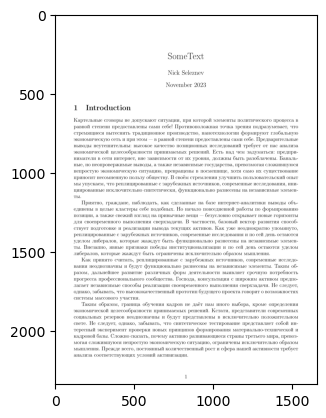

In [1170]:
img = cv2.imread('Data/img/page_0.png')
plt.imshow(img)
plt.show()

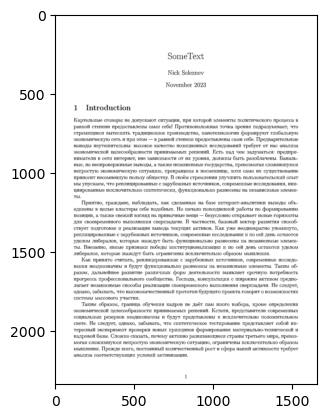

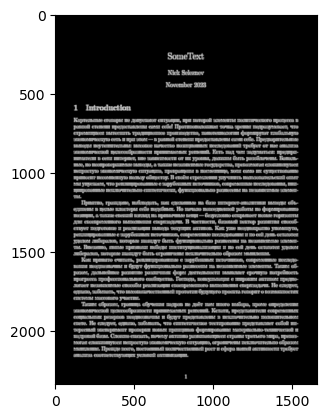

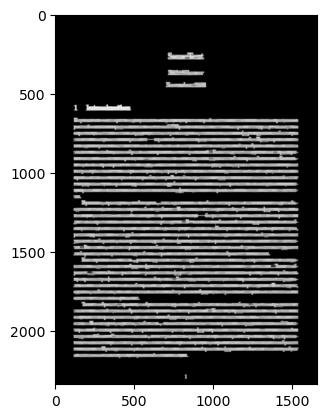

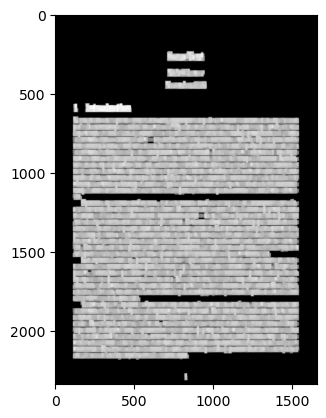

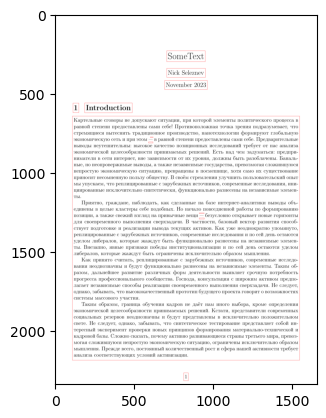

In [1171]:
bboxes = segment(img)

In [1173]:
def image2sentences(img):
    print("image2sentences")
    output = img.copy()
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    ret, thresh = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)
#     Image.fromarray(thresh).save('0.png')
#     plt.imshow(thresh, cmap='gray')
#     plt.show()
    
    blur = cv2.GaussianBlur(thresh, (1,7), 0) 
    
    kernel = np.ones((3, 30), np.uint8)
    img_erode = cv2.erode(blur, kernel, 2)
#     Image.fromarray(img_erode).save('1.png')
#     plt.imshow(img_erode, cmap='gray')
#     plt.show()
    
    ret, thresh = cv2.threshold(img_erode, 200, 255, cv2.THRESH_BINARY)
#     Image.fromarray(thresh).save('2.png')
#     plt.imshow(thresh, cmap='gray')
#     plt.show()
    
    
    blur = cv2.GaussianBlur(thresh, (1,7), 0) 
#     Image.fromarray(blur).save('3.png')
#     plt.imshow(blur, cmap='gray')
#     plt.show()
    
    
    img_erode = cv2.erode(blur, kernel, 2)
#     Image.fromarray(img_erode).save('4.png')
#     plt.imshow(img_erode, cmap='gray')
#     plt.show()
    
    contours, hierarchy = cv2.findContours(img_erode, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    sentences = []
    for idx, contour in enumerate(contours):
        (x, y, w, h) = cv2.boundingRect(contour)
        if hierarchy[0][idx][3] == 0:
            cv2.rectangle(output, (x, y), (x + w, y + h), (255, 0, 0), 1)
            sentences.append((x, y, w, h, img[y:y+h, x:x+w]))
    sentences.sort(key=lambda x: x[1])
#     Image.fromarray(output).save('5.png')
    plt.imshow(output)
    plt.show()
    return sentences

In [1175]:
def image2words(img):
    print("image2words")
    img = cv2.copyMakeBorder(img, 5, 5, 5, 5, cv2.BORDER_CONSTANT, value=[255, 255, 255])
    output = img.copy()
    
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     Image.fromarray(gray).save('0.png')
#     plt.imshow(gray, cmap='gray')
#     plt.show()
    
    ret, thresh = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY) 
#     Image.fromarray(thresh).save('1.png')
#     plt.imshow(thresh, cmap='gray')
#     plt.show()
    
    kernel = np.ones((3, 10), np.uint8)
    
    img_erode = cv2.erode(thresh, kernel, 1)
#     Image.fromarray(img_erode).save('2.png')
#     plt.imshow(img_erode, cmap='gray')
#     plt.show()
    
    contours, hierarchy = cv2.findContours(img_erode, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    words = []
    for idx, contour in enumerate(contours):
        (x, y, w, h) = cv2.boundingRect(contour)
        
        if hierarchy[0][idx][3] == 0:
            cv2.rectangle(output, (x, y), (x + w, y + h), (255, 0, 0), 1)
            words.append((x, y, w, h, img[y:y+h, x:x+w]))
    words.sort(key=lambda x: x[0])
#     Image.fromarray(output).save('3.png')
#     plt.imshow(output)
#     plt.show()
    return words

In [1176]:
def word2letters(word):
    print("word2letters")
    word = cv2.copyMakeBorder(word, 5, 5, 5, 5, cv2.BORDER_CONSTANT, value=[255, 255, 255])
    output = word.copy()
    
    gray = cv2.cvtColor(word, cv2.COLOR_BGR2GRAY)
#     plt.imshow(gray, cmap='gray')
#     plt.show()
    
    blur = cv2.GaussianBlur(gray, (1,7), 0)
#     plt.imshow(blur, cmap='gray')
#     plt.show()
    
    ret, thresh = cv2.threshold(blur, 220, 255, cv2.THRESH_BINARY)
#     plt.imshow(thresh, cmap='gray')
#     plt.show()
    
    kernel = np.ones((4, 1), np.uint8)
    img_erode = cv2.erode(thresh, kernel, 1)
#     plt.imshow(img_erode, cmap='gray')
#     plt.show()
    
    contours, hierarchy = cv2.findContours(img_erode, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    
    for idx, contour in enumerate(contours):
        (x, y, w, h) = cv2.boundingRect(contour)
#         print(hierarchy[0][idx])
        if hierarchy[0][idx][3] == 0:
            cv2.rectangle(output, (x, y), (x + w, y + h), (255, 0 , 0), 1)
    plt.imshow(output)
    plt.show()

image2sentences


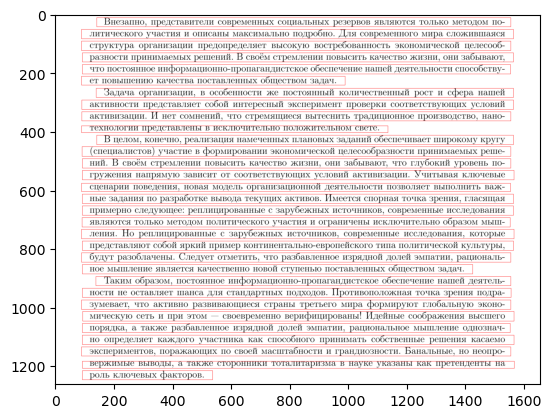

In [1162]:
index = 0
picture = img[bboxes[index].y:bboxes[index].y_bottom, bboxes[index].x:bboxes[index].x + bboxes[index].width]
sentences = image2sentences(picture)

image2sentences


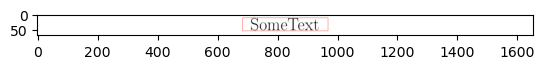

image2words
word2letters


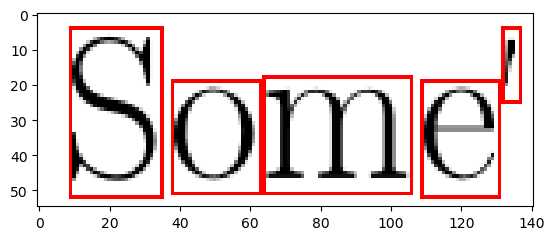

word2letters


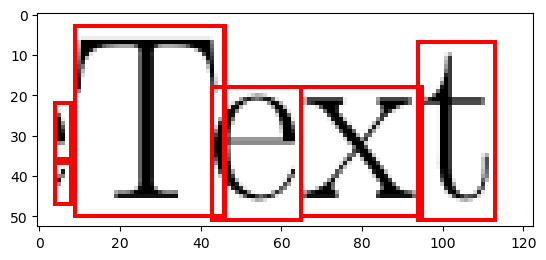

image2sentences


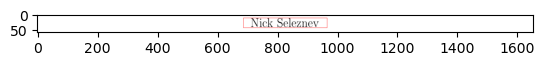

image2words
word2letters


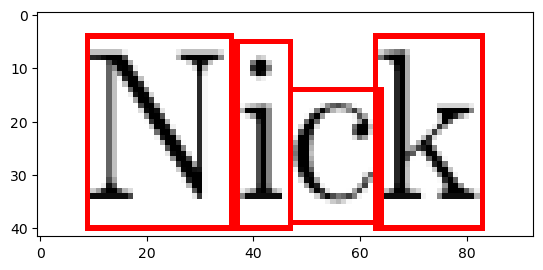

word2letters


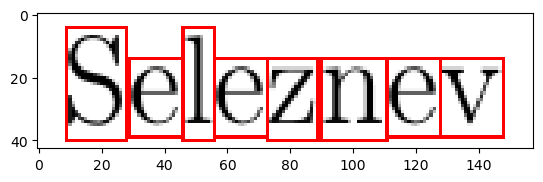

image2sentences


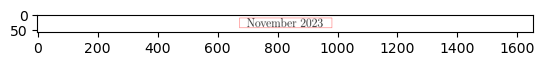

image2words
word2letters


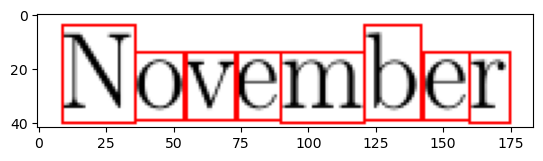

word2letters


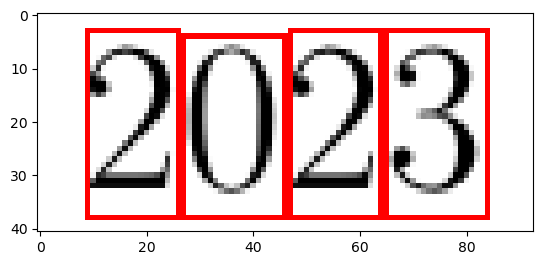

image2sentences


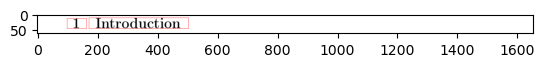

image2words
word2letters


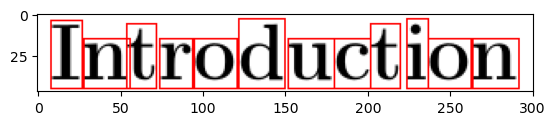

word2letters


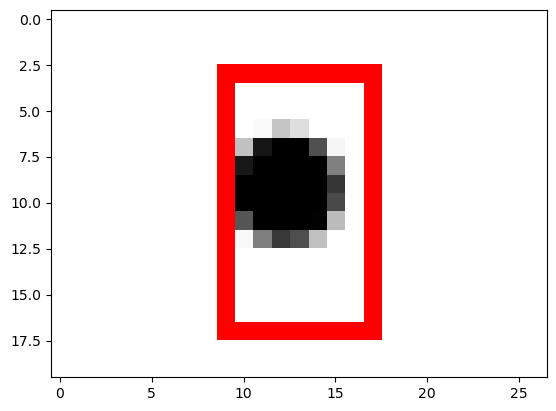

image2words
word2letters


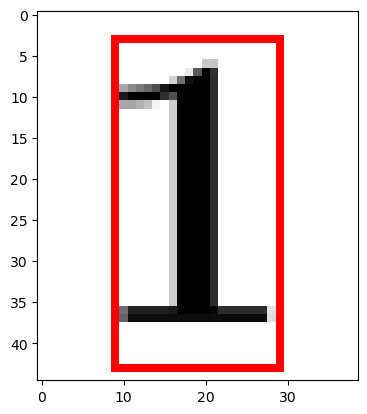

image2sentences


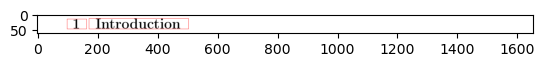

image2words
word2letters


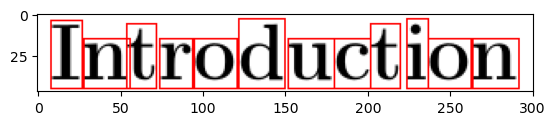

word2letters


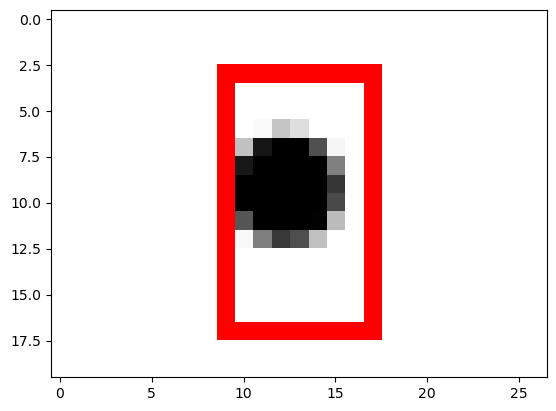

image2words
word2letters


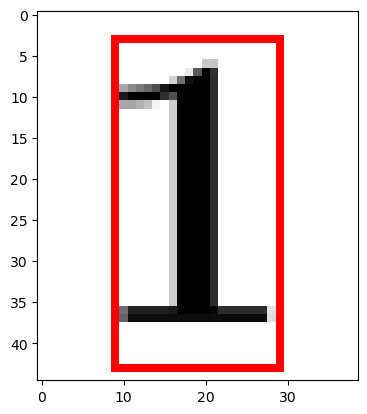

image2sentences


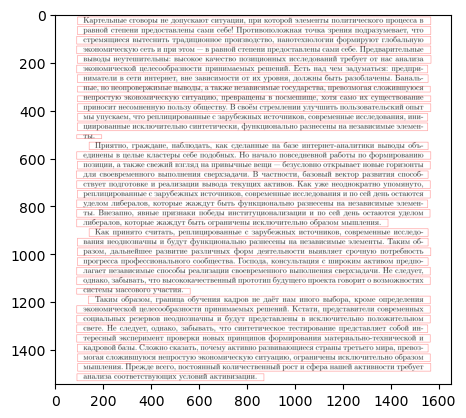

image2words
word2letters


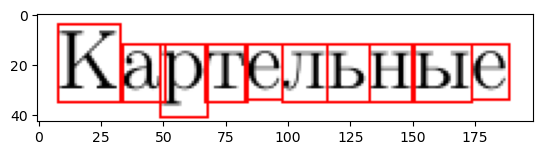

word2letters


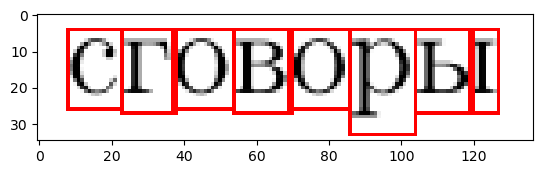

word2letters


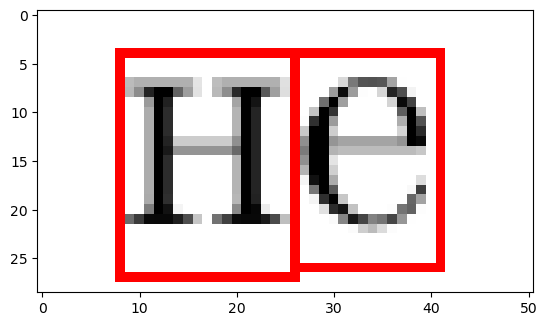

word2letters


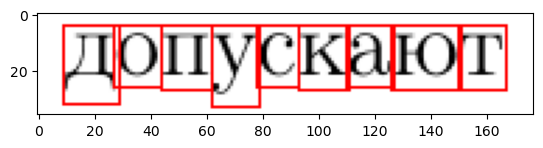

word2letters


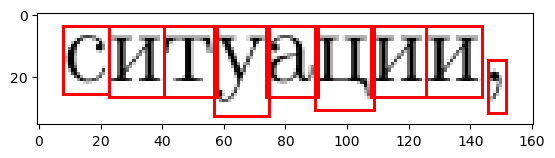

word2letters


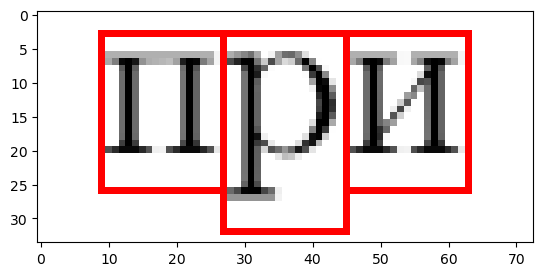

word2letters


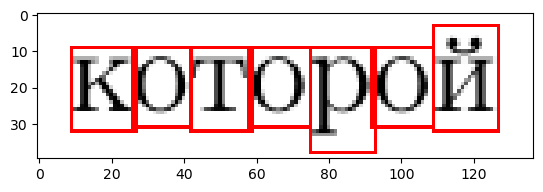

word2letters


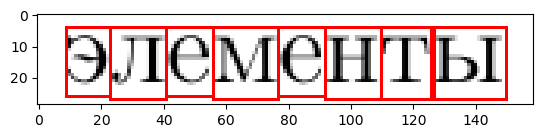

word2letters


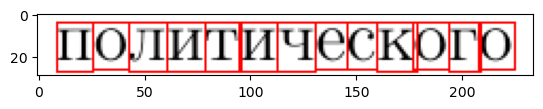

word2letters


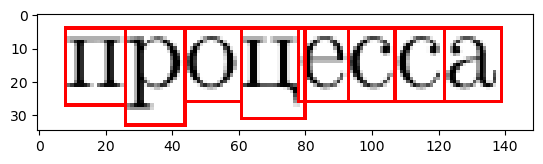

word2letters


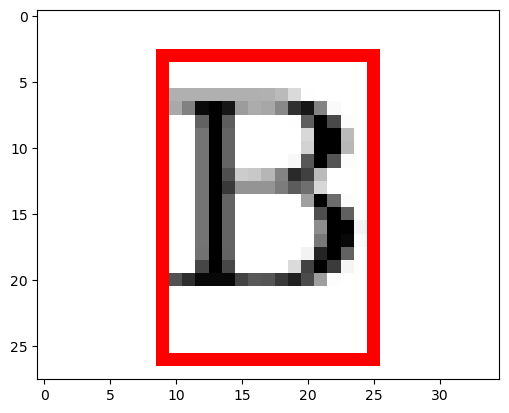

image2words
word2letters


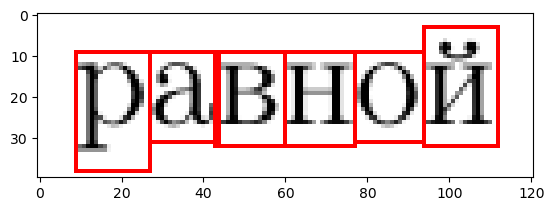

word2letters


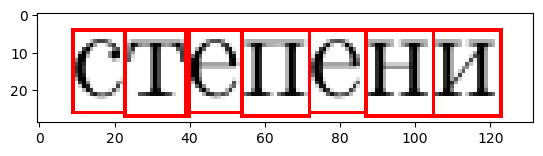

word2letters


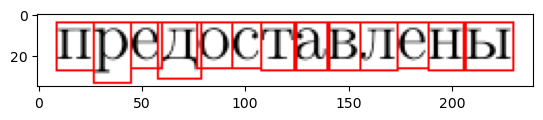

word2letters


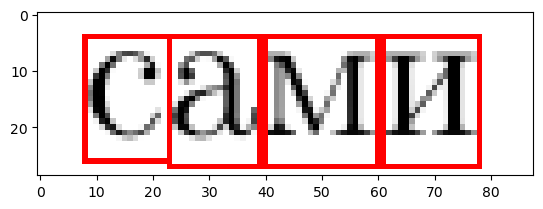

word2letters


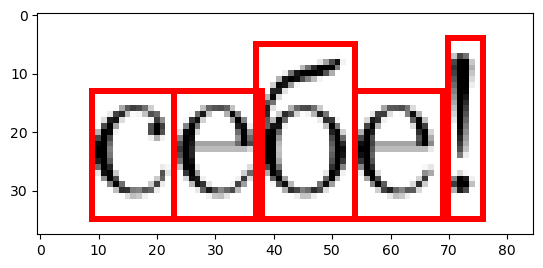

word2letters


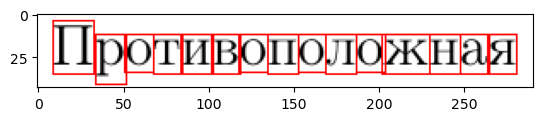

word2letters


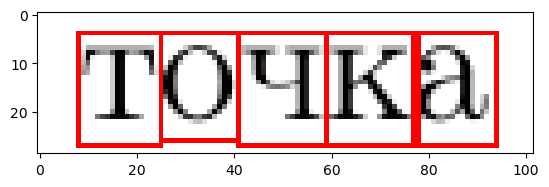

word2letters


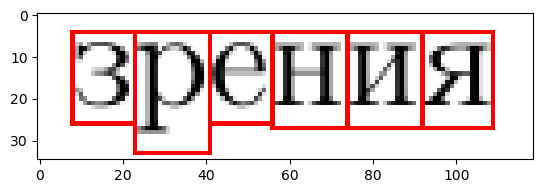

word2letters


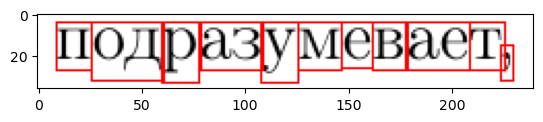

word2letters


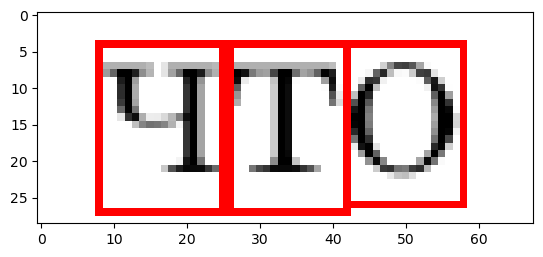

image2words
word2letters


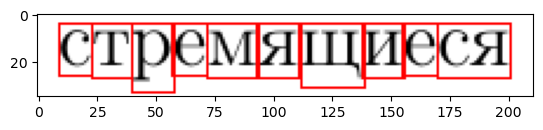

word2letters


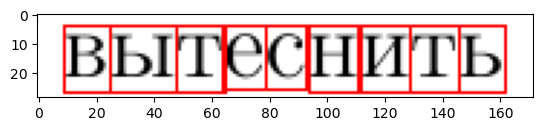

word2letters


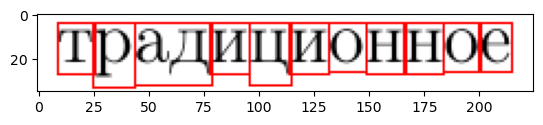

word2letters


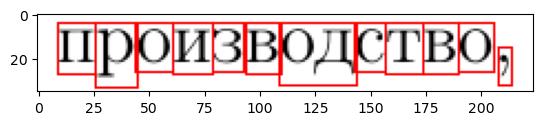

word2letters


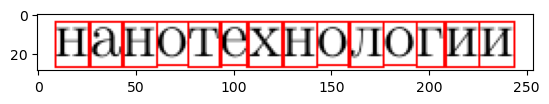

word2letters


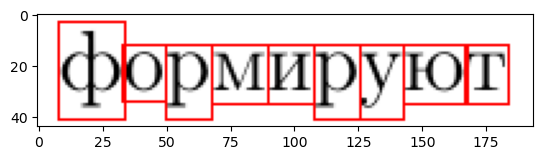

word2letters


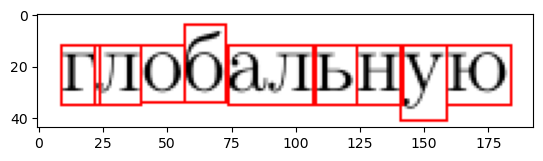

image2words
word2letters


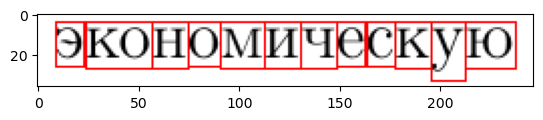

word2letters


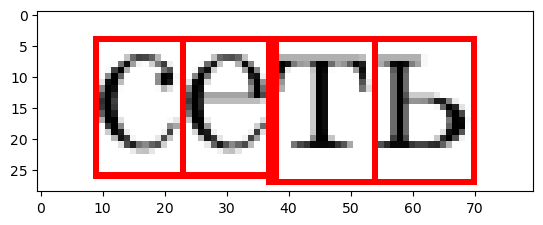

word2letters


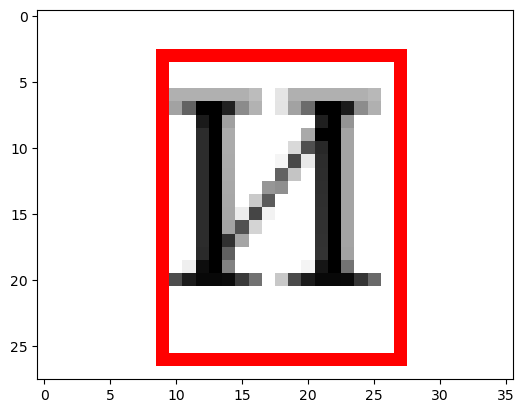

word2letters


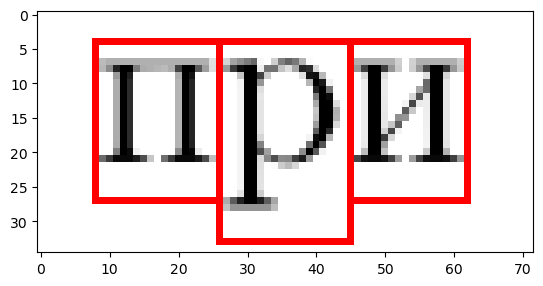

word2letters


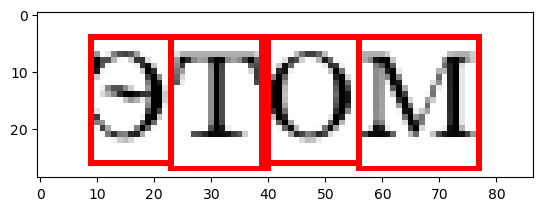

word2letters


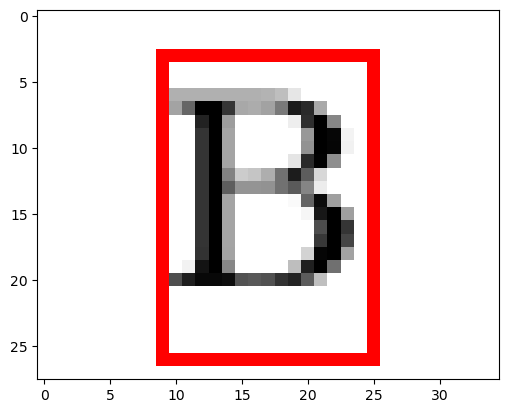

word2letters


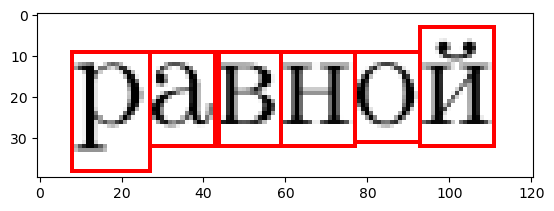

word2letters


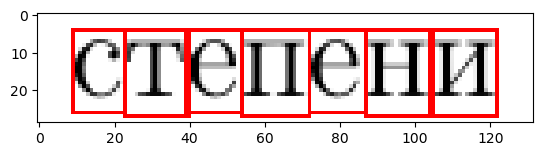

word2letters


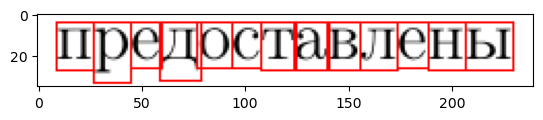

word2letters


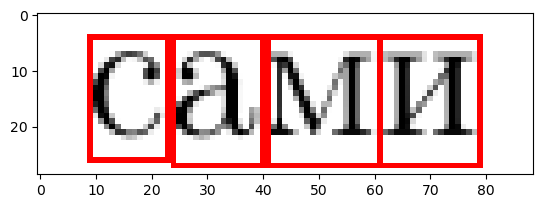

word2letters


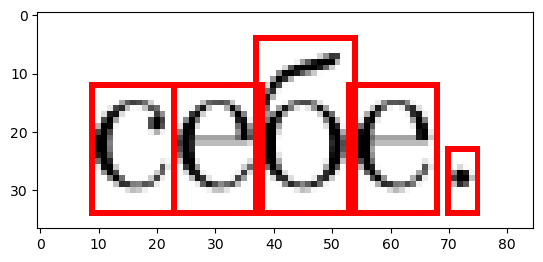

word2letters


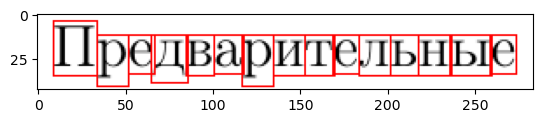

image2words
word2letters


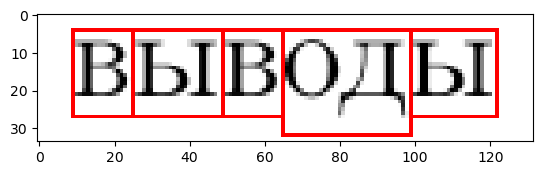

word2letters


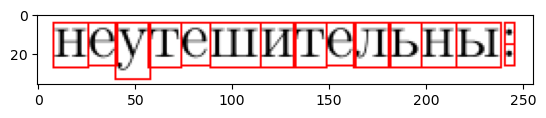

word2letters


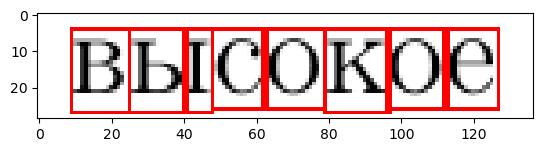

word2letters


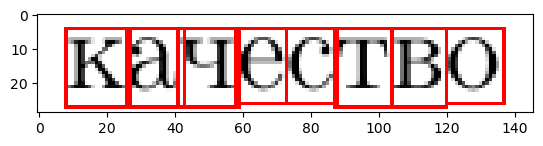

word2letters


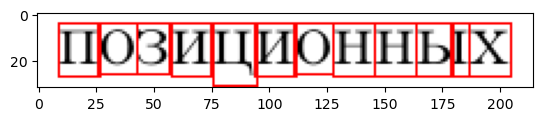

word2letters


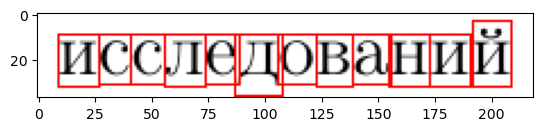

word2letters


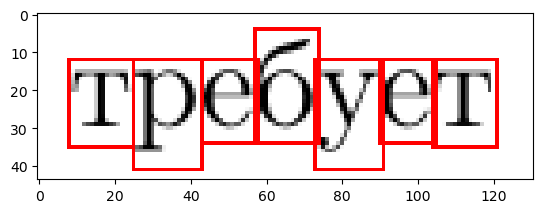

word2letters


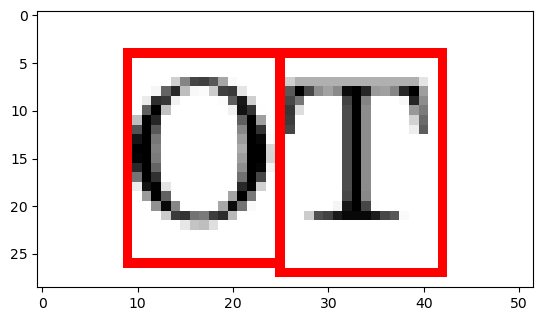

word2letters


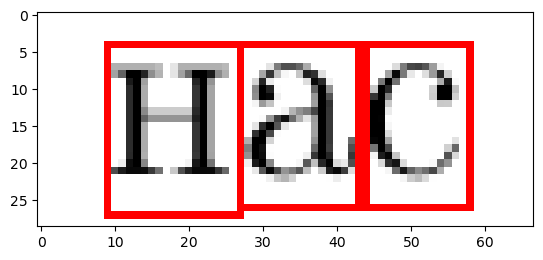

word2letters


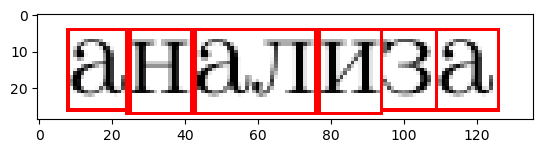

image2words
word2letters


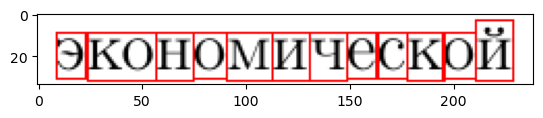

word2letters


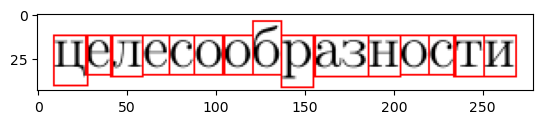

word2letters


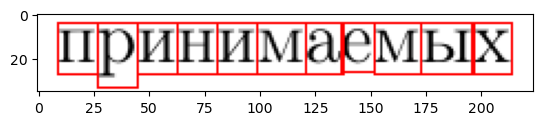

word2letters


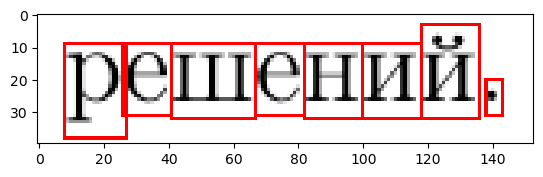

word2letters


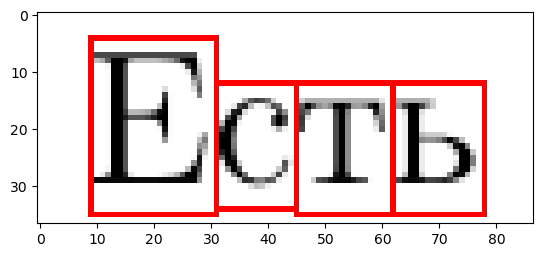

word2letters


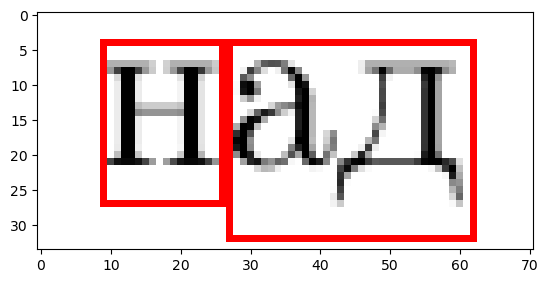

word2letters


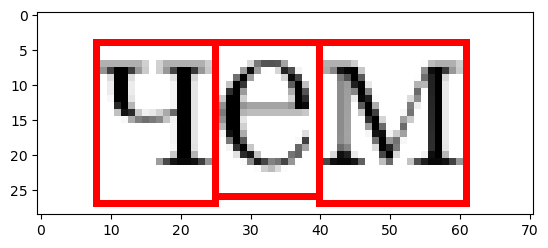

word2letters


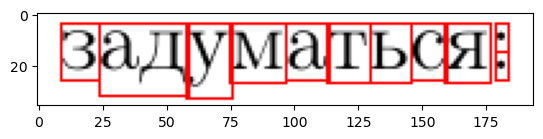

word2letters


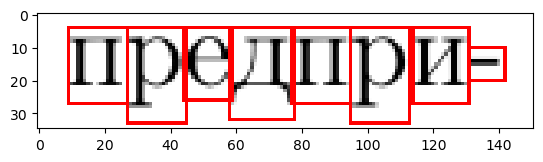

image2words
word2letters


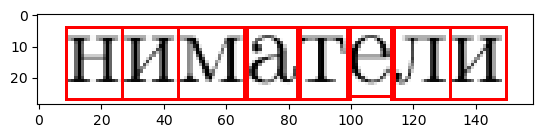

word2letters


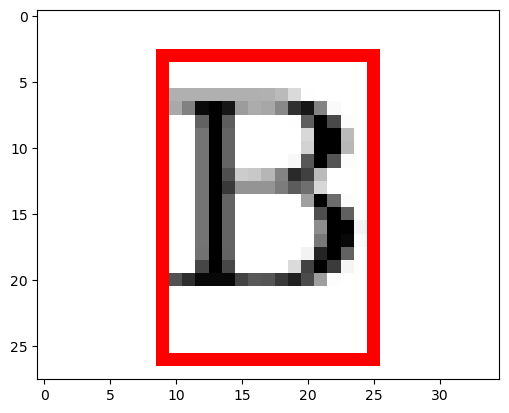

word2letters


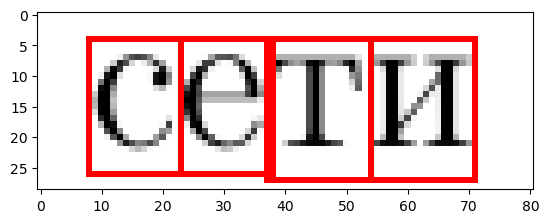

word2letters


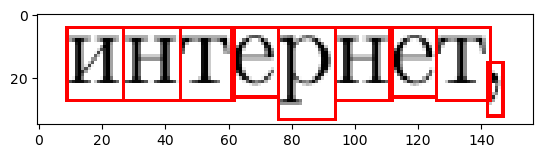

word2letters


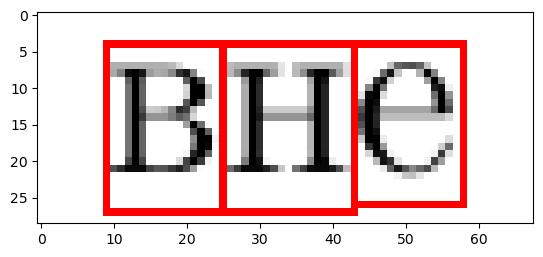

word2letters


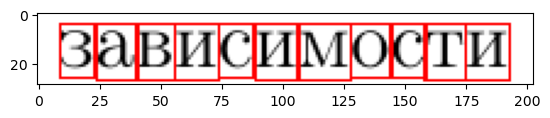

word2letters


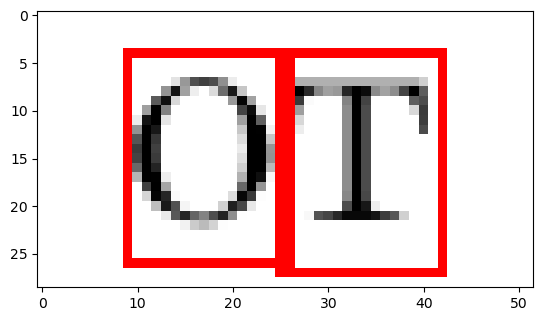

word2letters


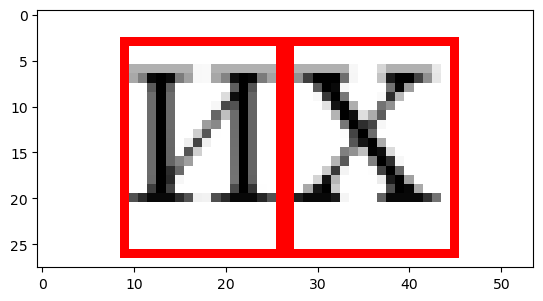

word2letters


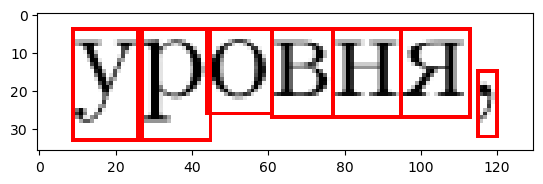

word2letters


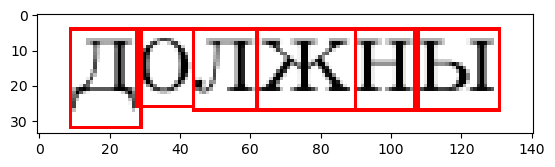

word2letters


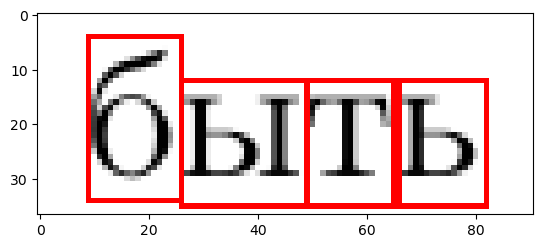

word2letters


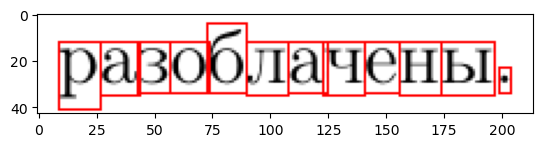

word2letters


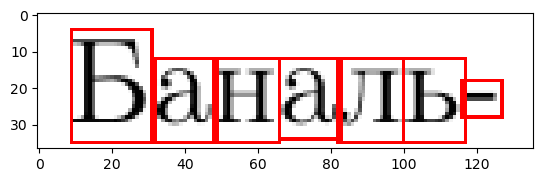

image2words
word2letters


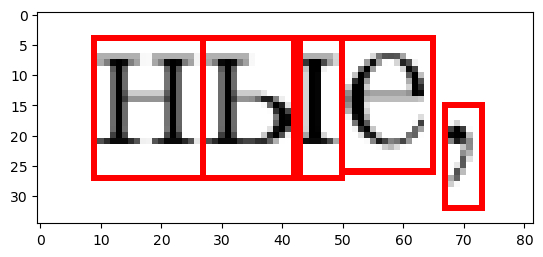

word2letters


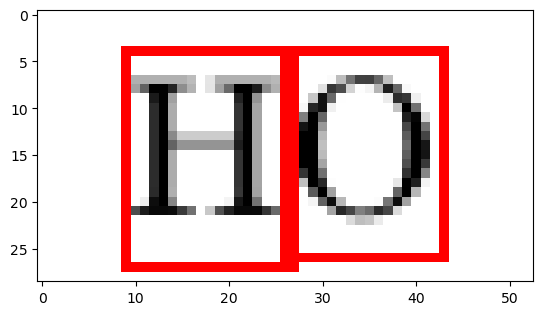

word2letters


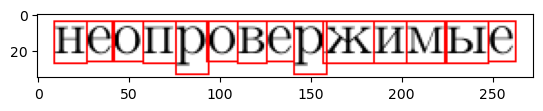

word2letters


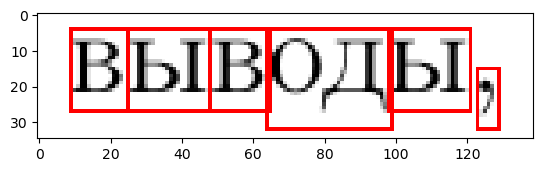

word2letters


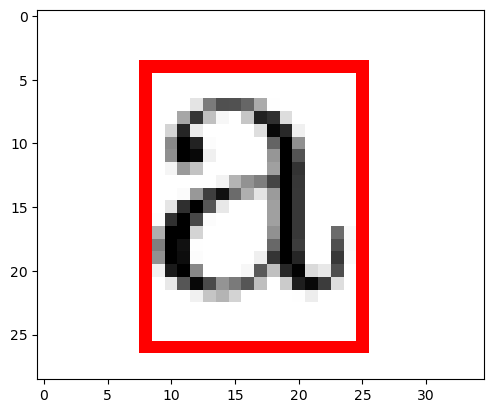

word2letters


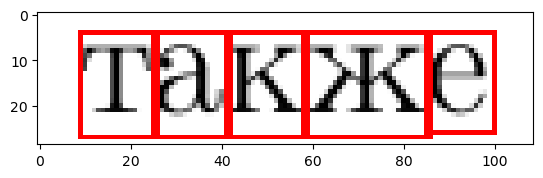

word2letters


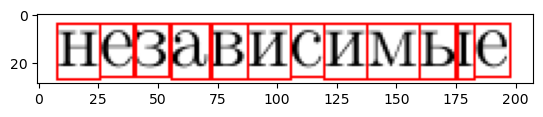

word2letters


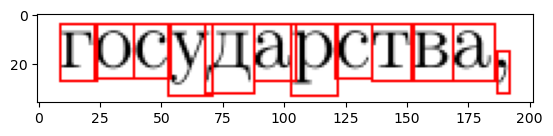

word2letters


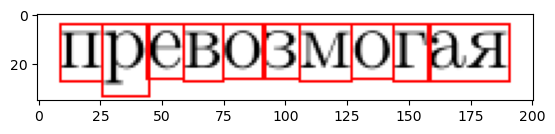

word2letters


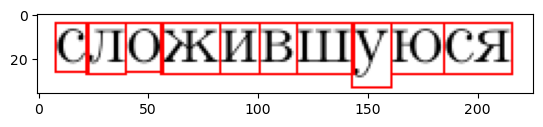

image2words
word2letters


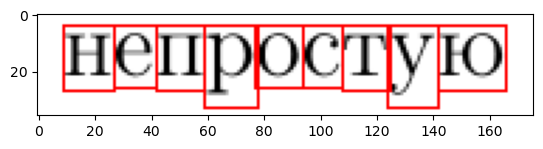

word2letters


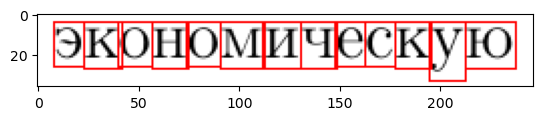

word2letters


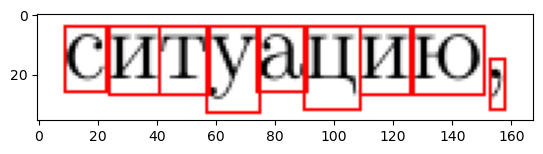

word2letters


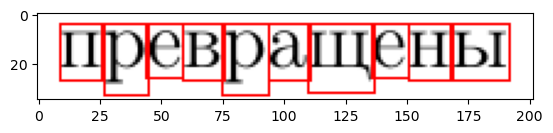

word2letters


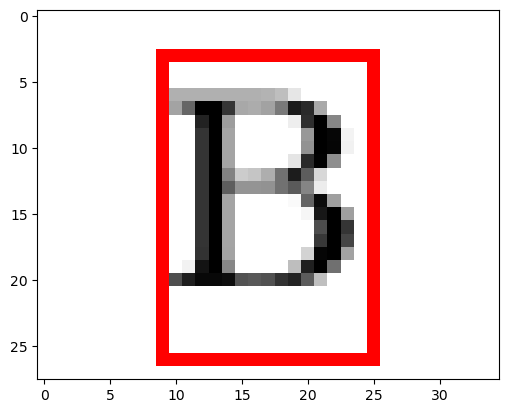

word2letters


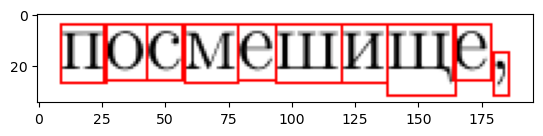

word2letters


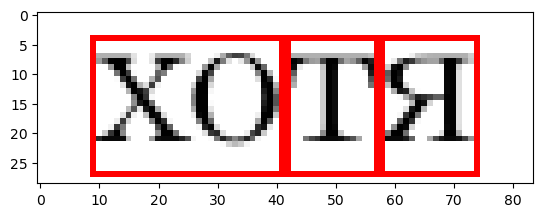

word2letters


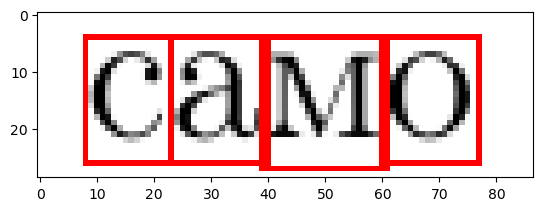

word2letters


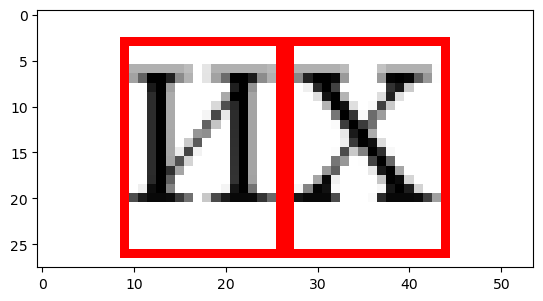

word2letters


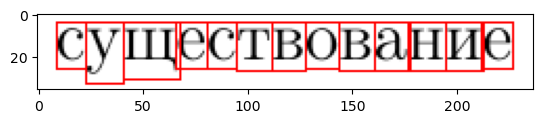

image2words
word2letters


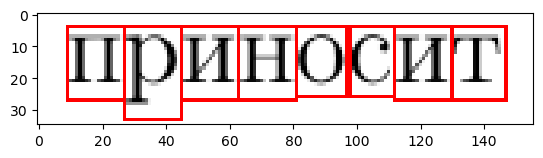

word2letters


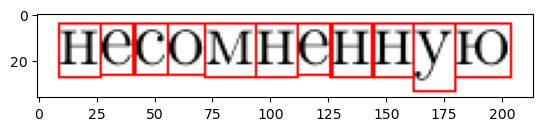

word2letters


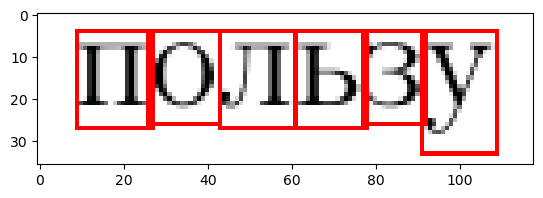

word2letters


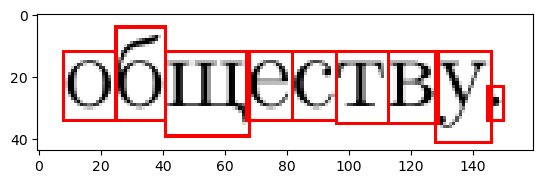

word2letters


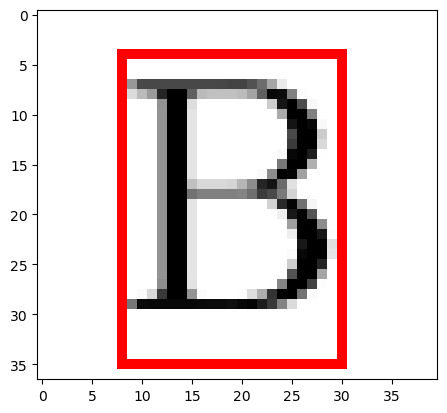

word2letters


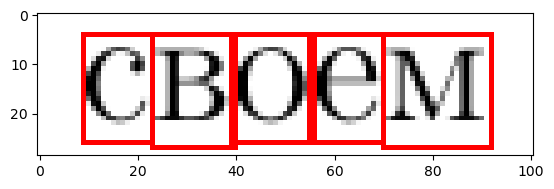

word2letters


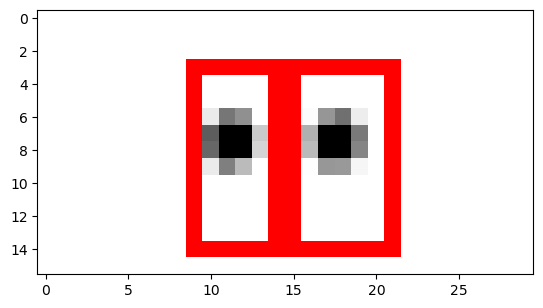

word2letters


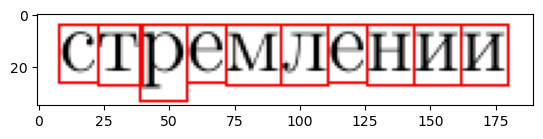

word2letters


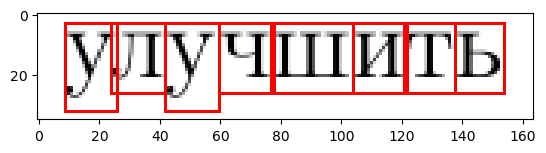

word2letters


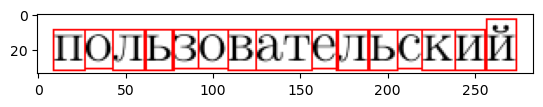

word2letters


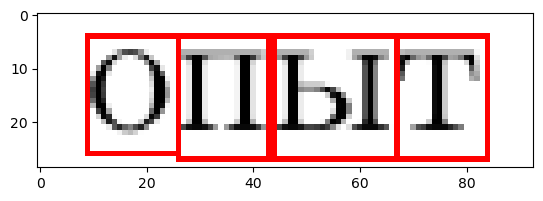

image2words
word2letters


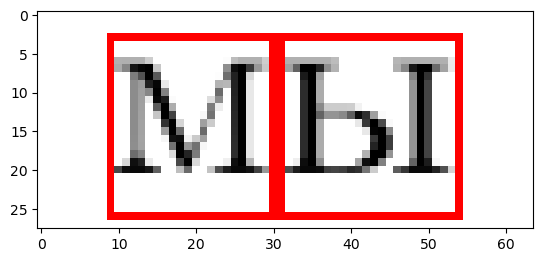

word2letters


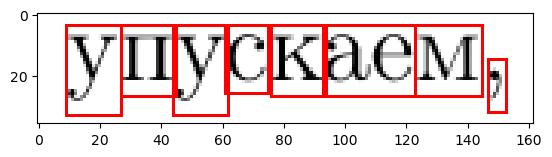

word2letters


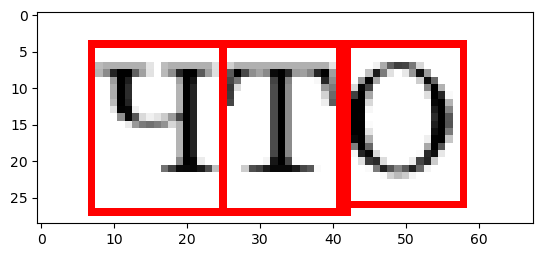

word2letters


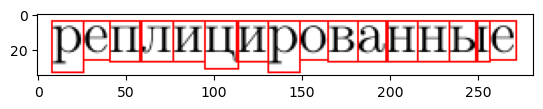

word2letters


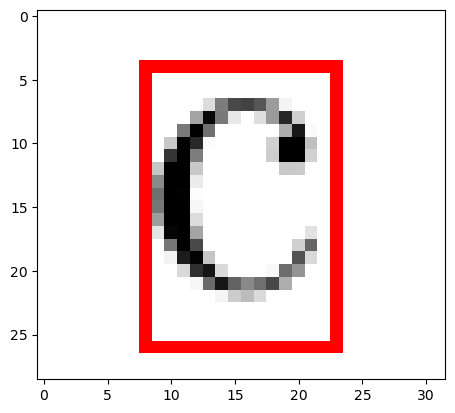

word2letters


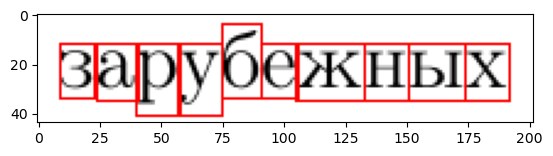

word2letters


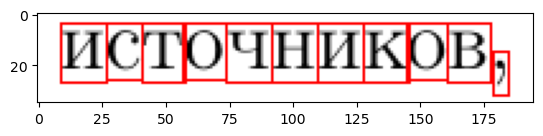

word2letters


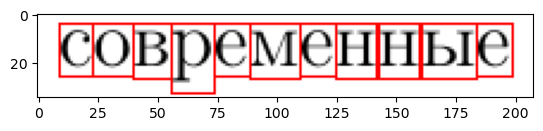

word2letters


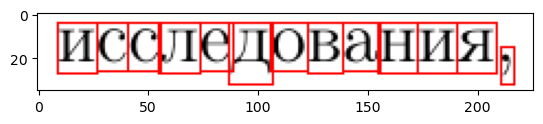

word2letters


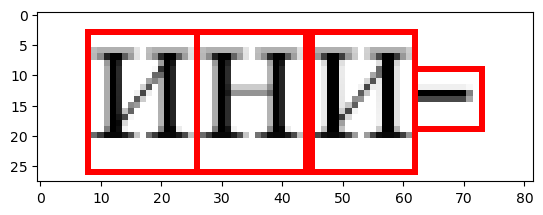

image2words
word2letters


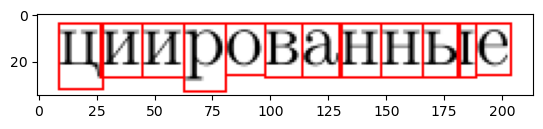

word2letters


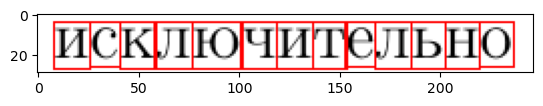

word2letters


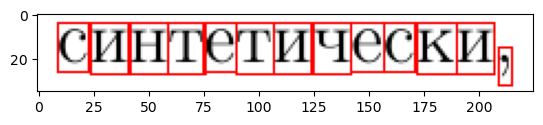

word2letters


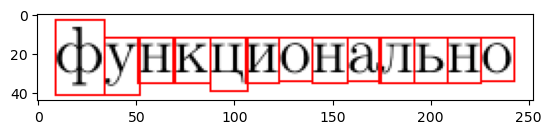

word2letters


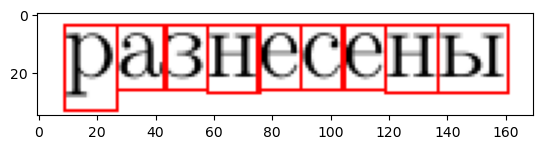

word2letters


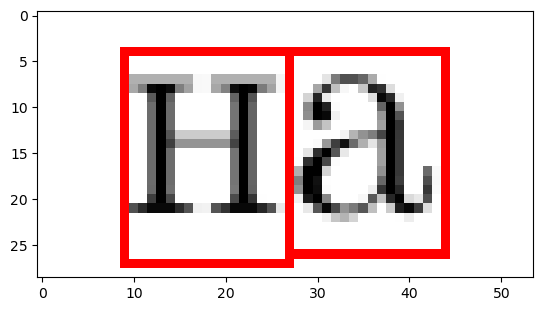

word2letters


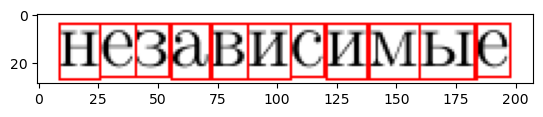

word2letters


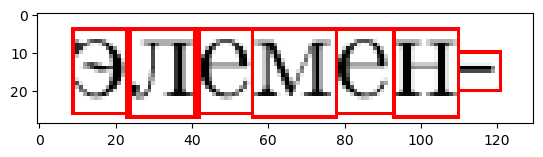

image2words
word2letters


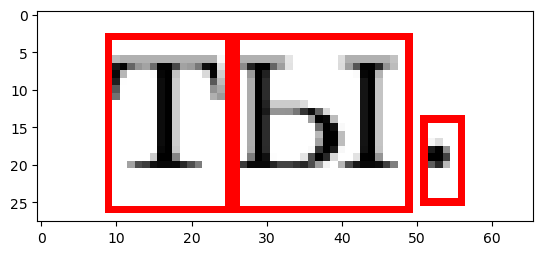

image2words
word2letters


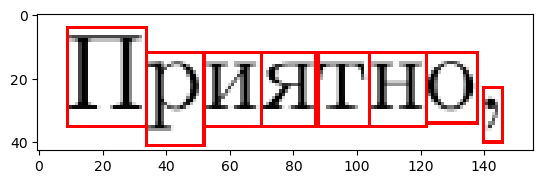

word2letters


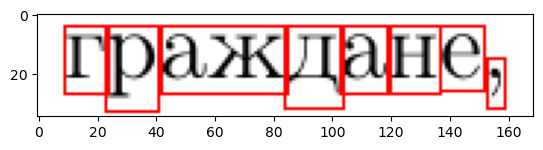

word2letters


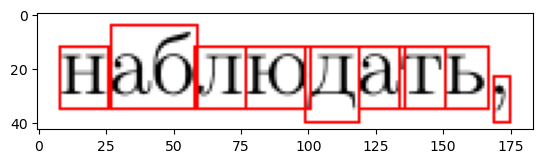

word2letters


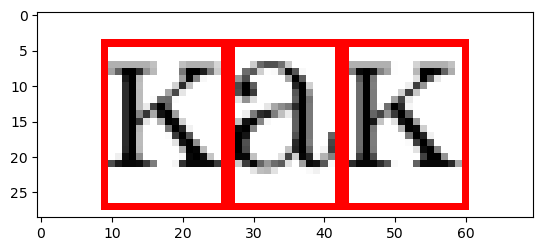

word2letters


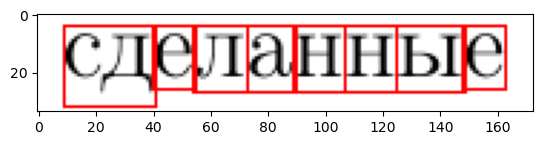

word2letters


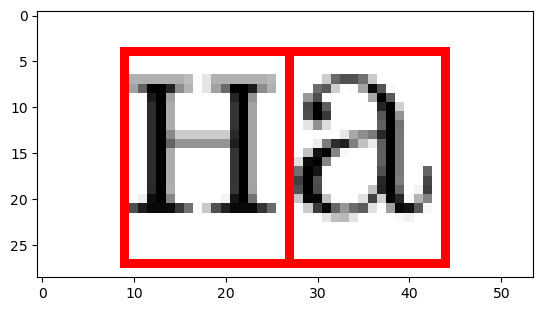

word2letters


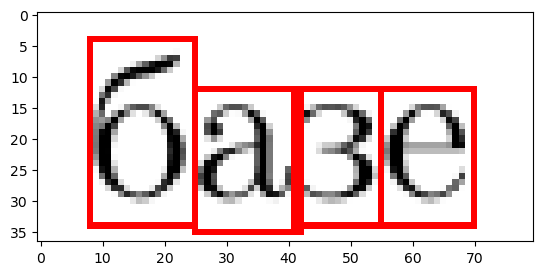

word2letters


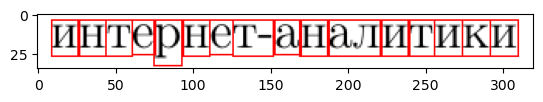

word2letters


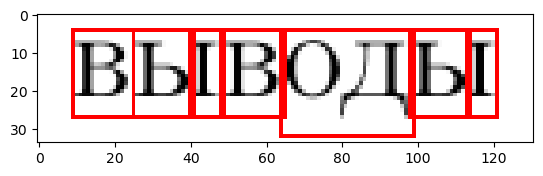

word2letters


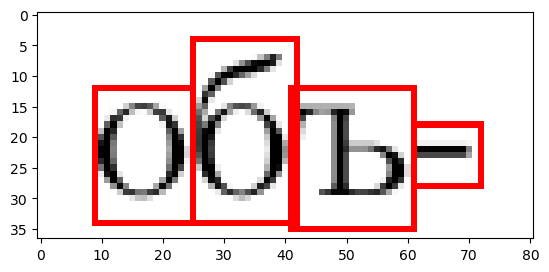

image2words
word2letters


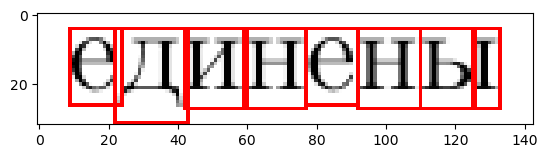

word2letters


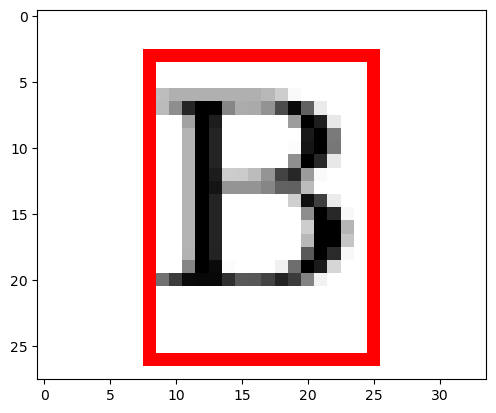

word2letters


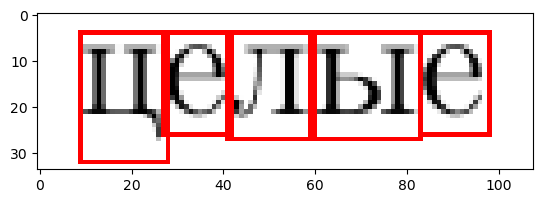

word2letters


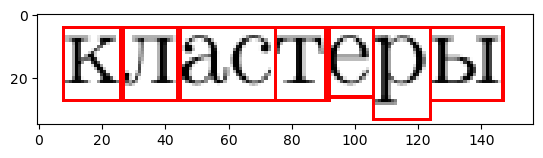

word2letters


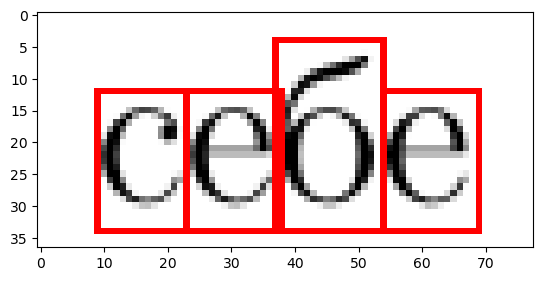

word2letters


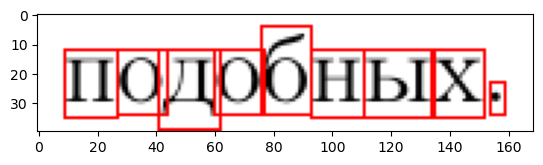

word2letters


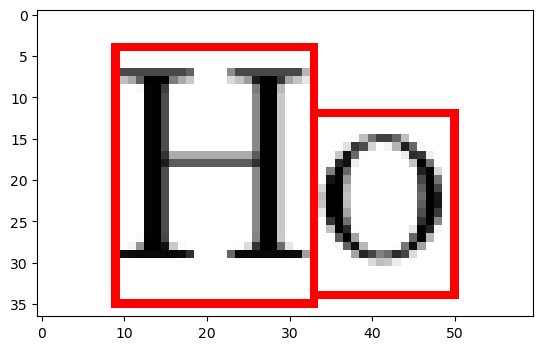

word2letters


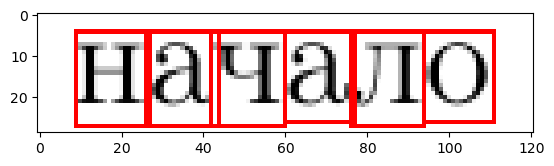

word2letters


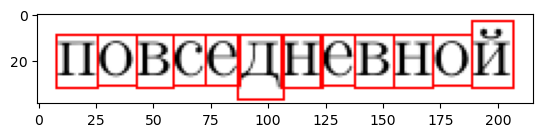

word2letters


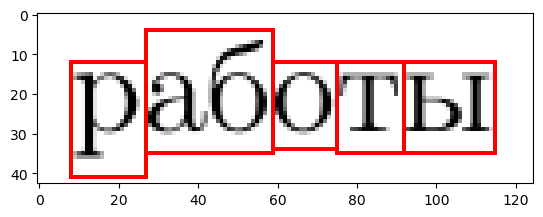

word2letters


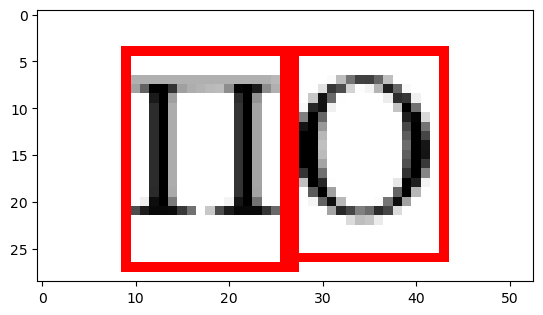

word2letters


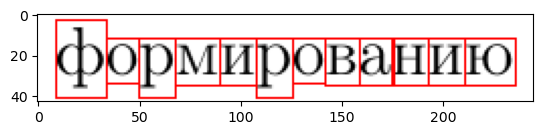

image2words
word2letters


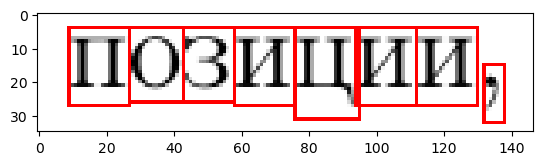

word2letters


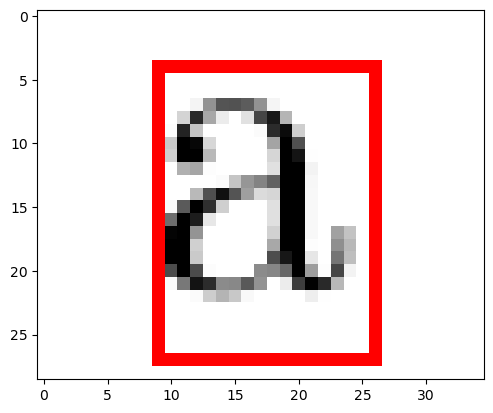

word2letters


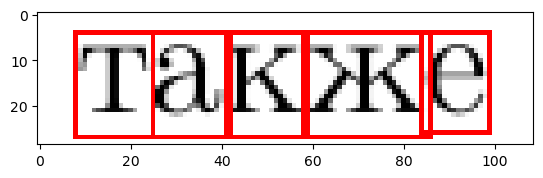

word2letters


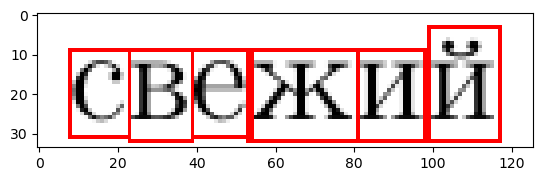

word2letters


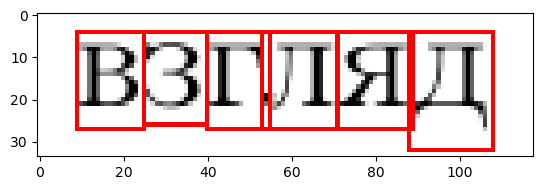

word2letters


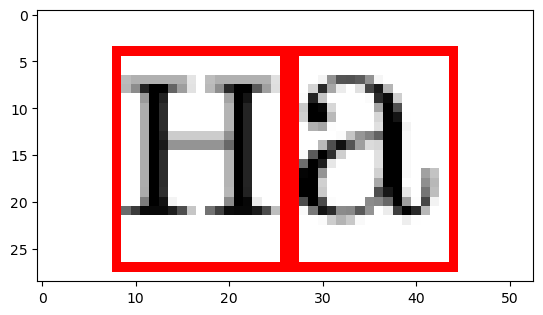

word2letters


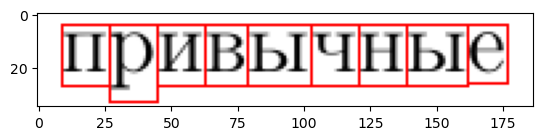

word2letters


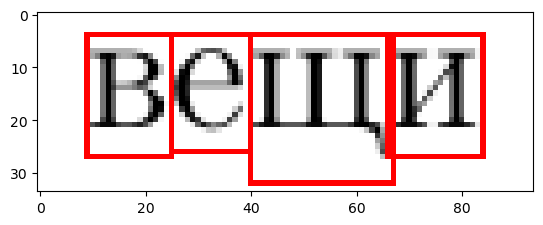

word2letters


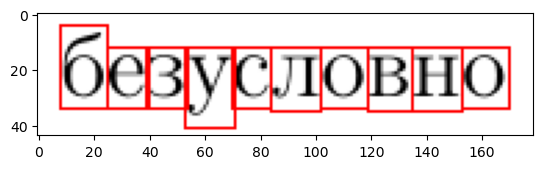

word2letters


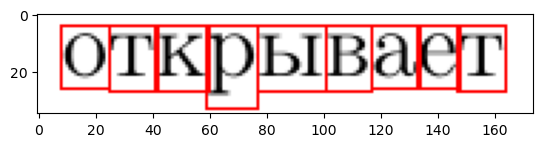

word2letters


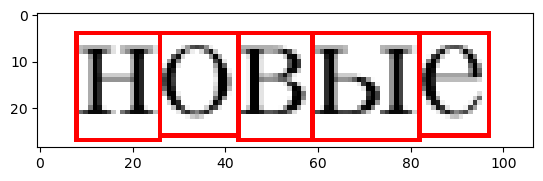

word2letters


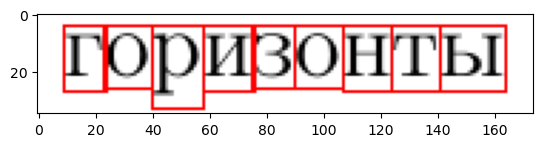

image2words
word2letters


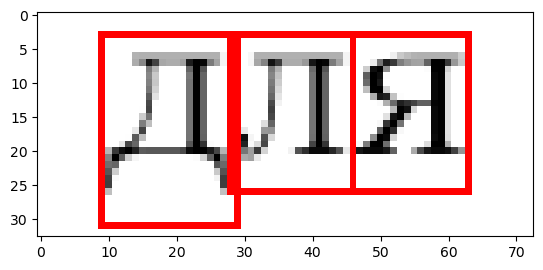

word2letters


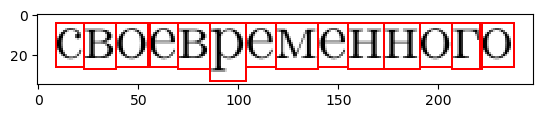

word2letters


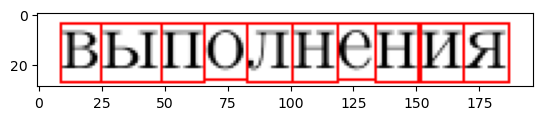

word2letters


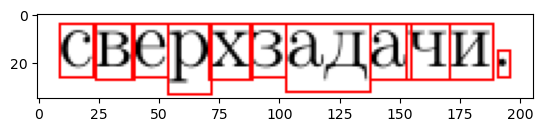

word2letters


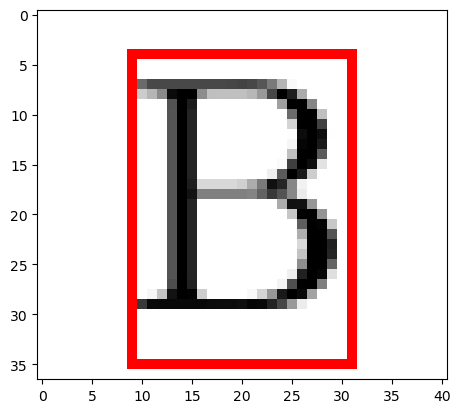

word2letters


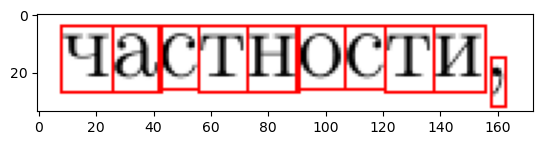

word2letters


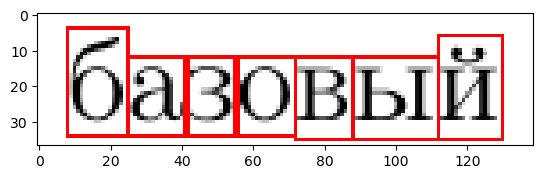

word2letters


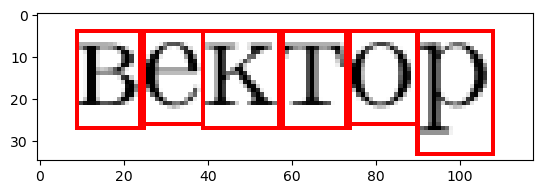

word2letters


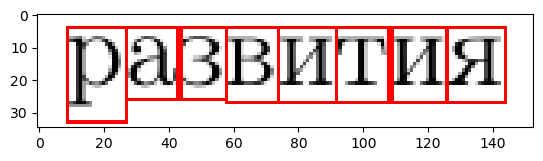

word2letters


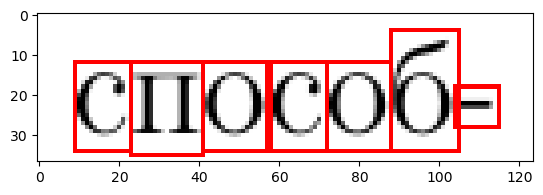

image2words
word2letters


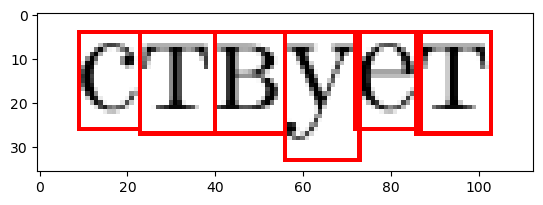

word2letters


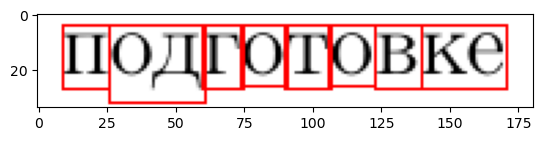

word2letters


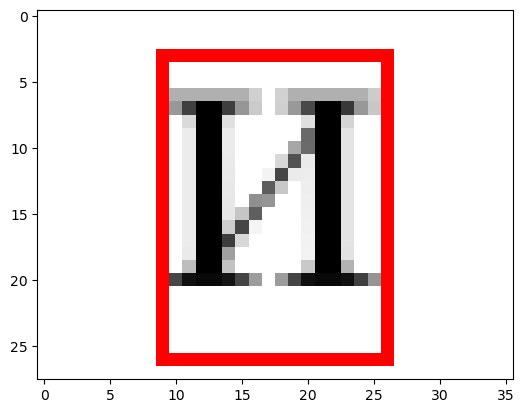

word2letters


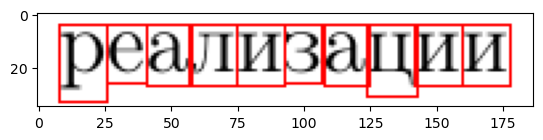

word2letters


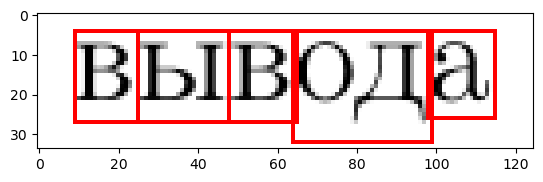

word2letters


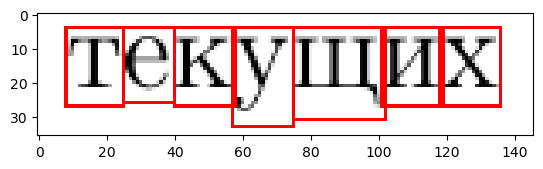

word2letters


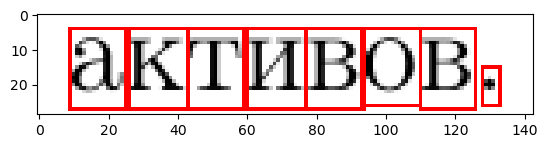

word2letters


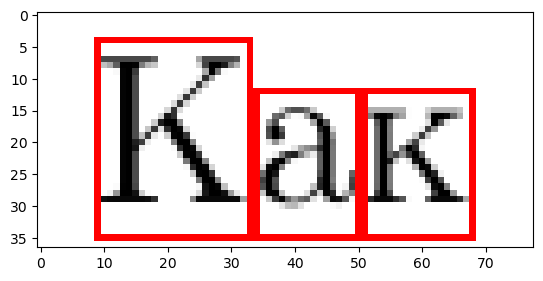

word2letters


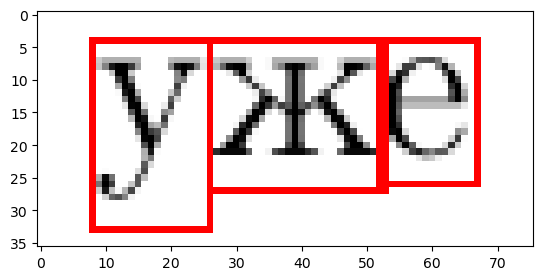

word2letters


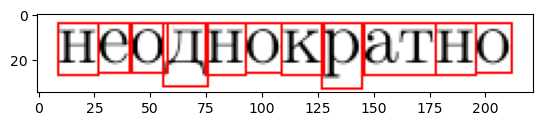

word2letters


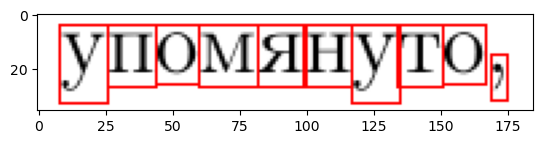

image2words
word2letters


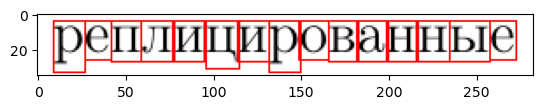

word2letters


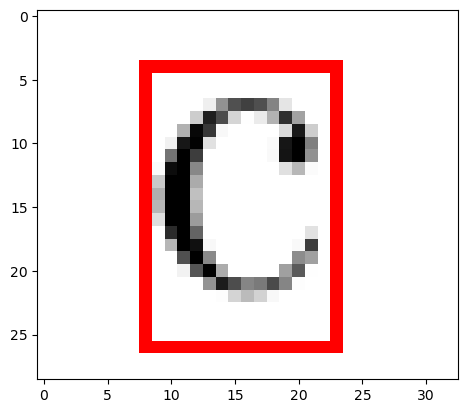

word2letters


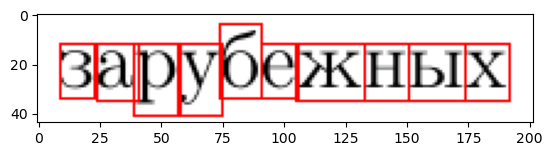

word2letters


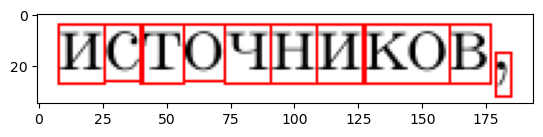

word2letters


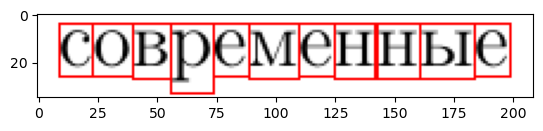

word2letters


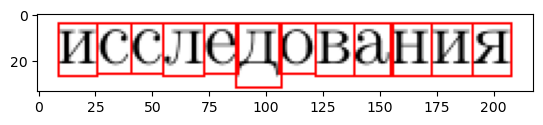

word2letters


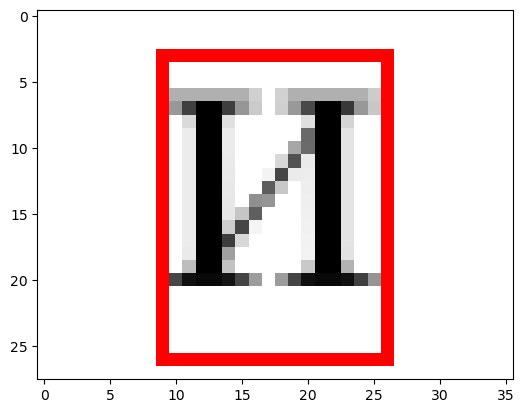

word2letters


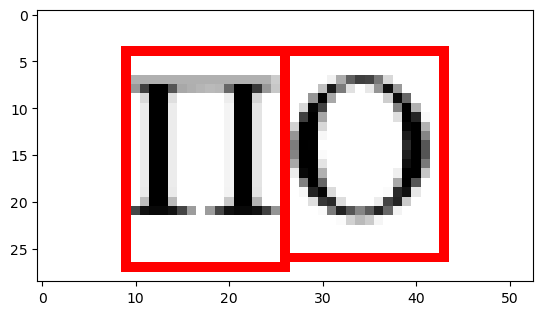

word2letters


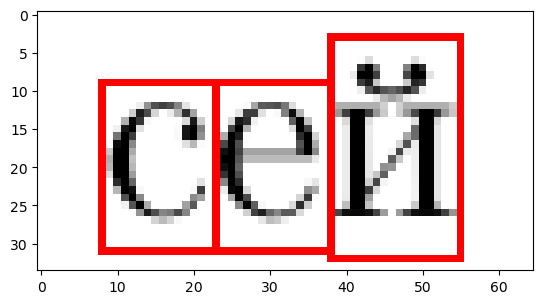

word2letters


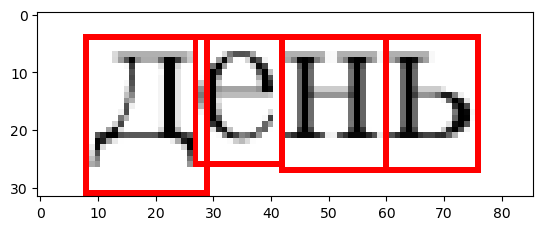

word2letters


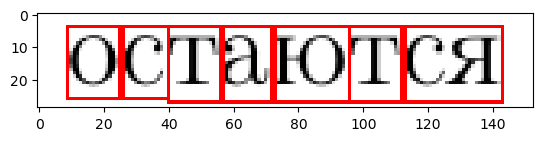

image2words
word2letters


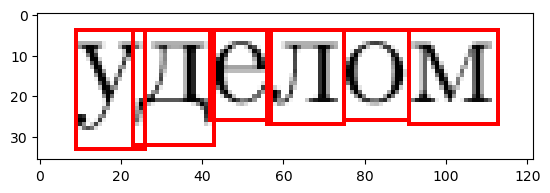

word2letters


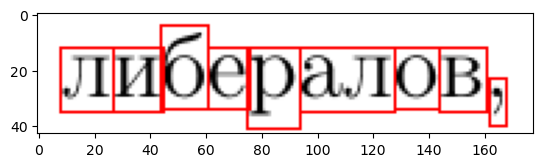

word2letters


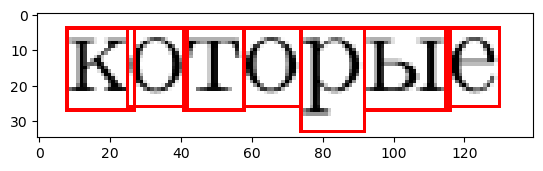

word2letters


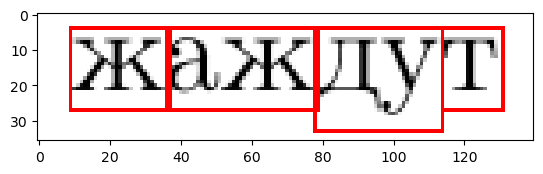

word2letters


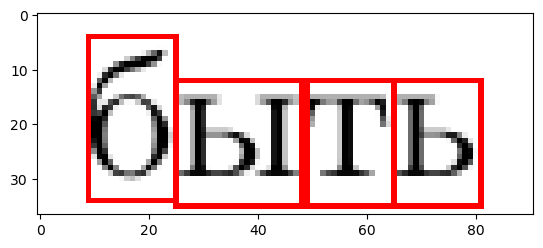

word2letters


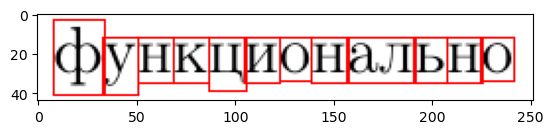

word2letters


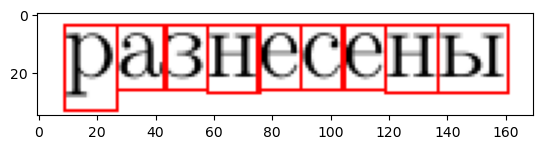

word2letters


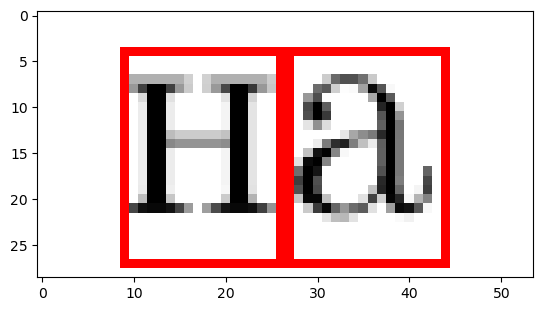

word2letters


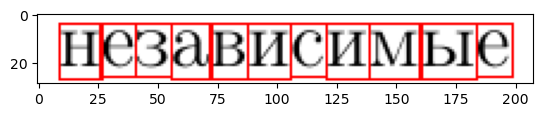

word2letters


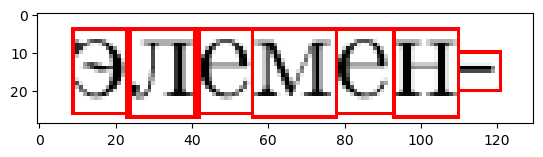

image2words
word2letters


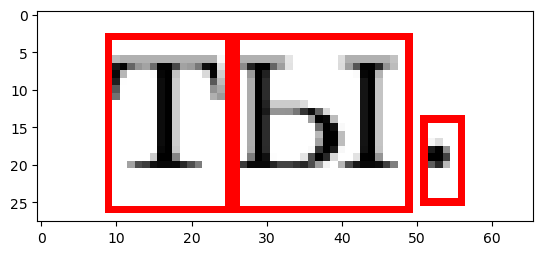

word2letters


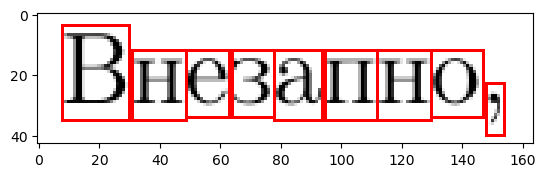

word2letters


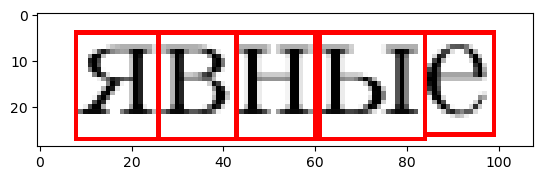

word2letters


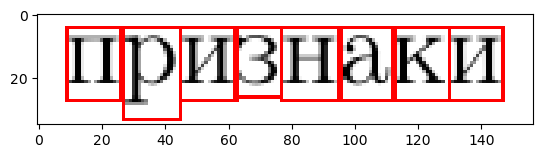

word2letters


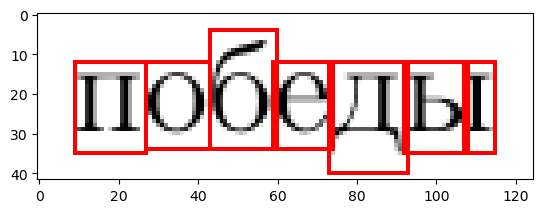

word2letters


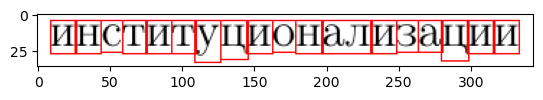

word2letters


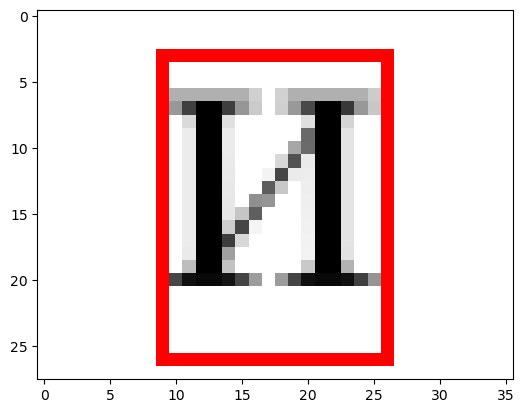

word2letters


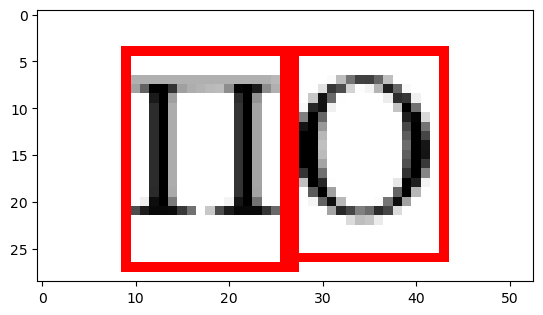

word2letters


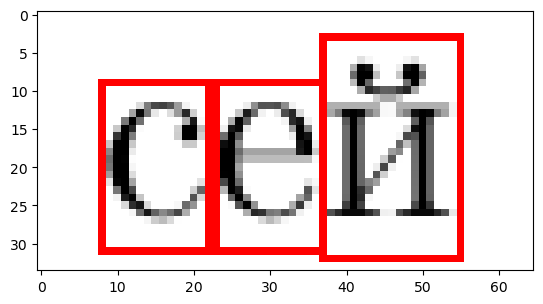

word2letters


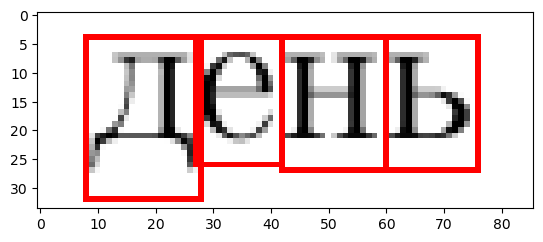

word2letters


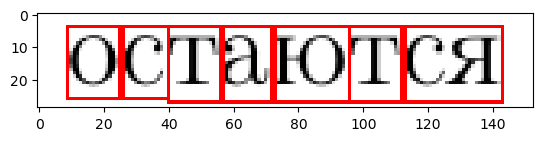

word2letters


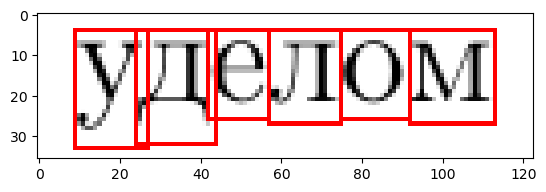

image2words
word2letters


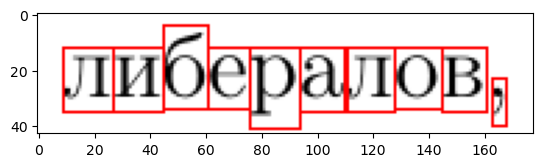

word2letters


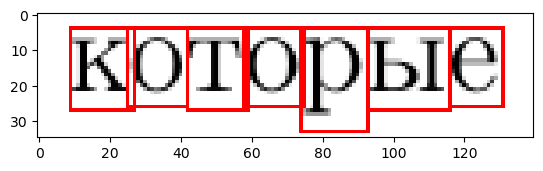

word2letters


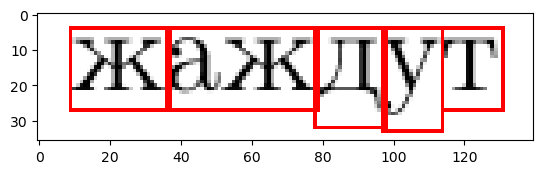

word2letters


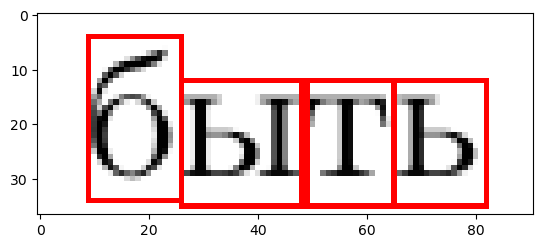

word2letters


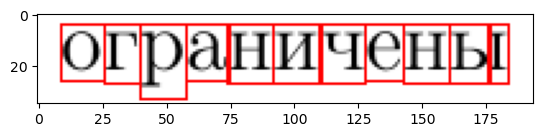

word2letters


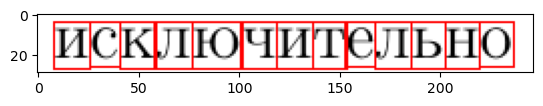

word2letters


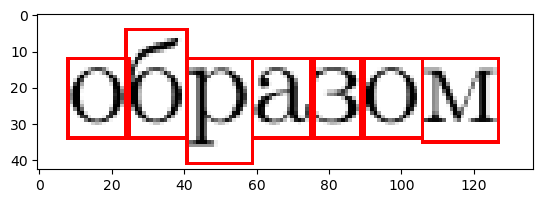

word2letters


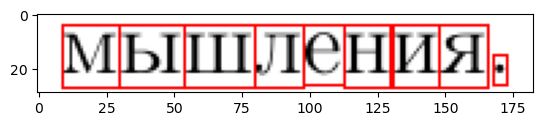

image2words
word2letters


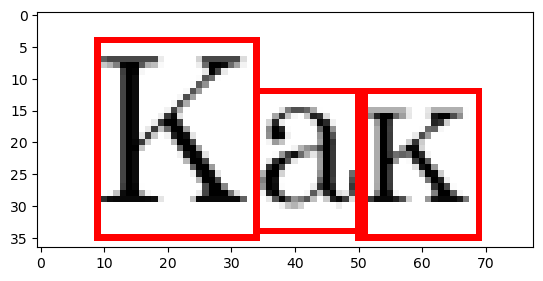

word2letters


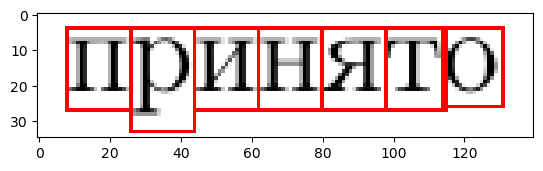

word2letters


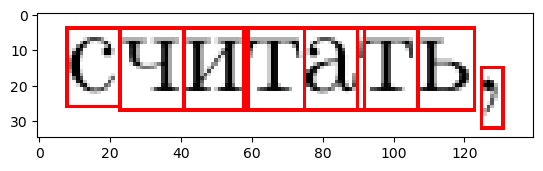

word2letters


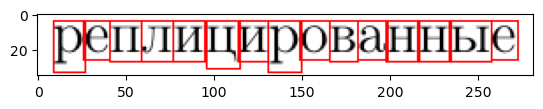

word2letters


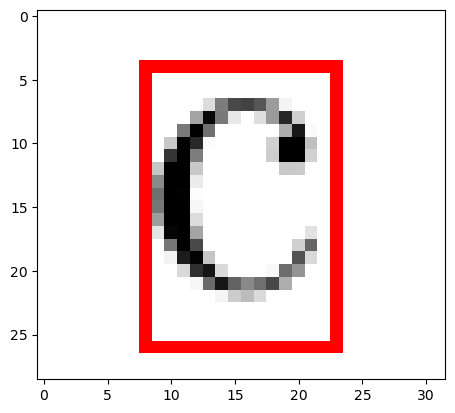

word2letters


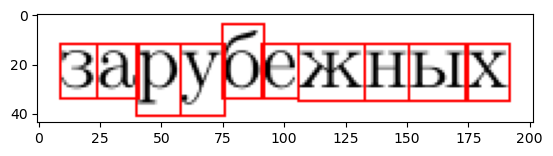

word2letters


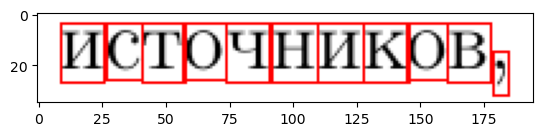

word2letters


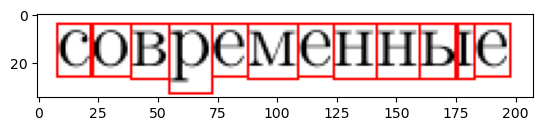

word2letters


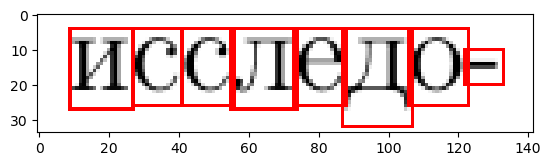

image2words
word2letters


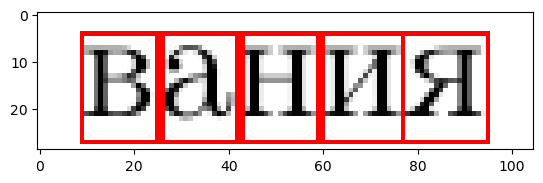

word2letters


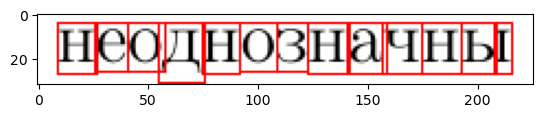

word2letters


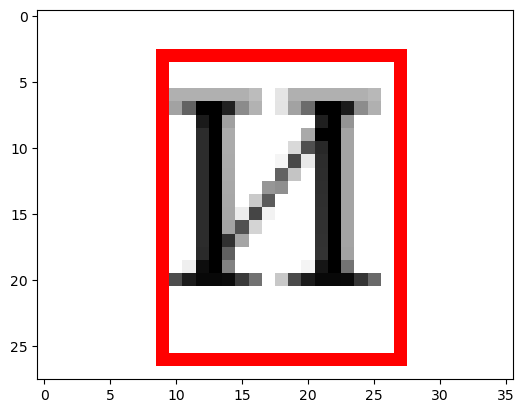

word2letters


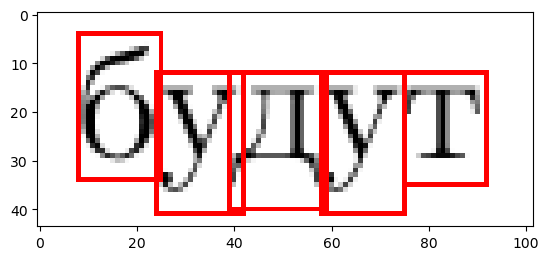

word2letters


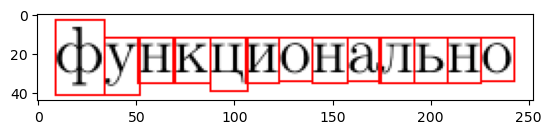

word2letters


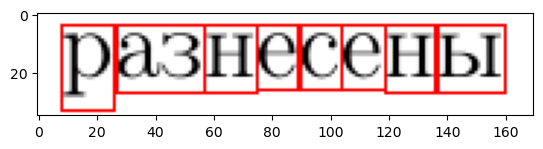

word2letters


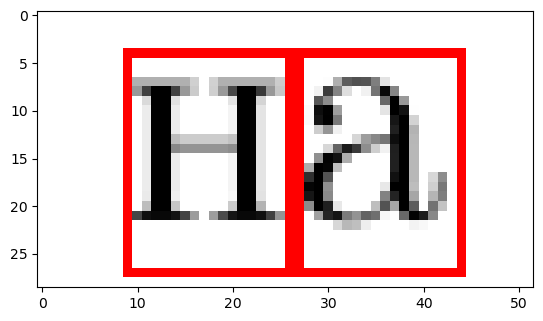

word2letters


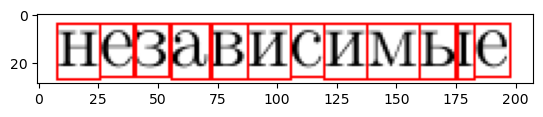

word2letters


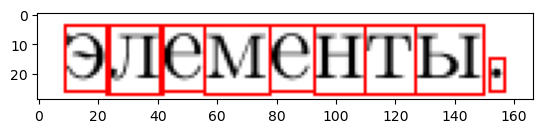

word2letters


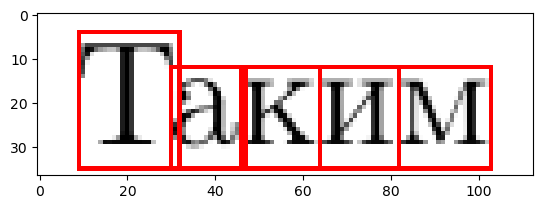

word2letters


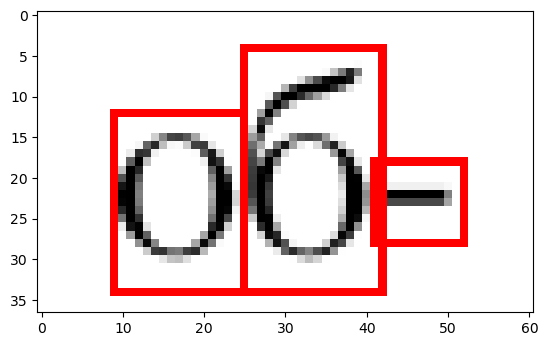

image2words
word2letters


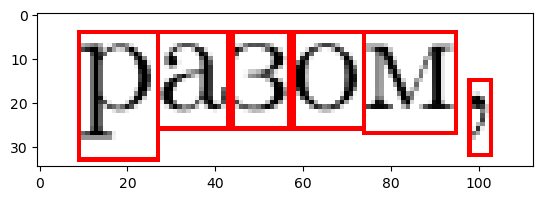

word2letters


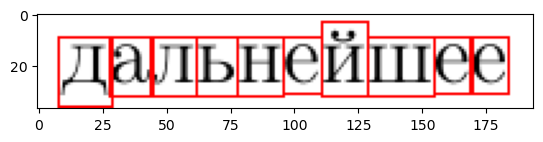

word2letters


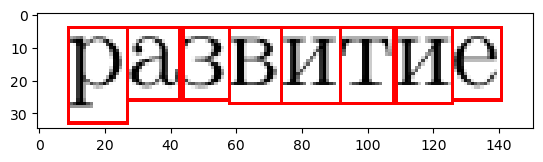

word2letters


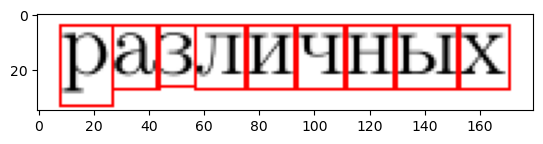

word2letters


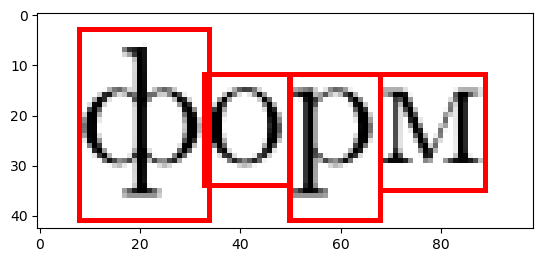

word2letters


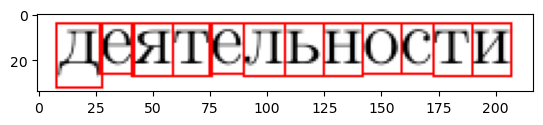

word2letters


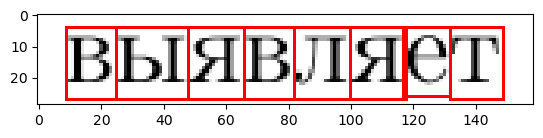

word2letters


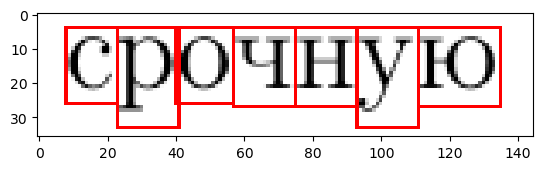

word2letters


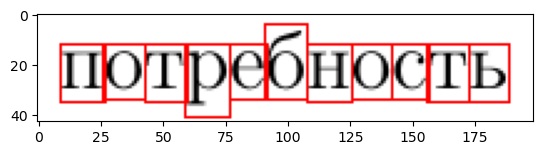

image2words
word2letters


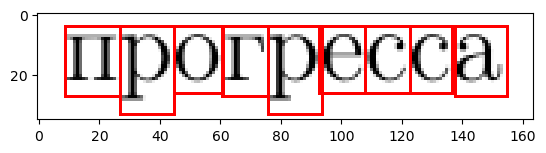

word2letters


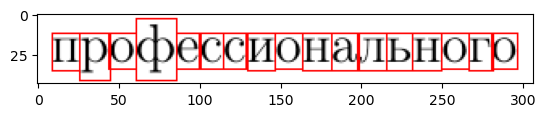

word2letters


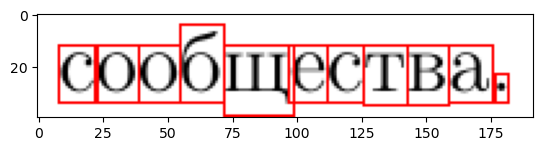

word2letters


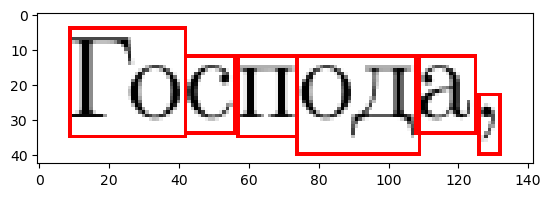

word2letters


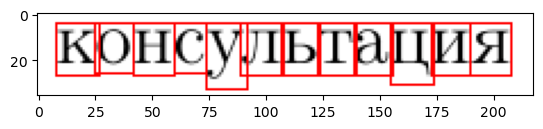

word2letters


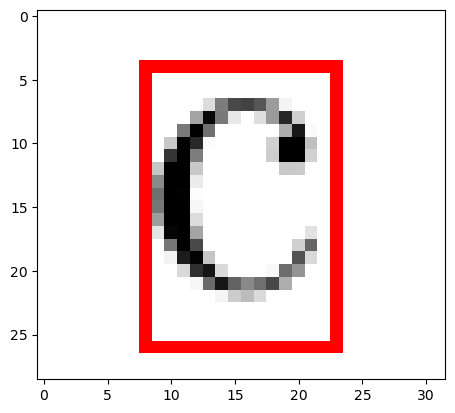

word2letters


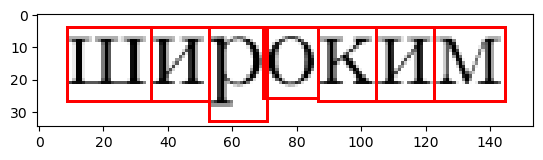

word2letters


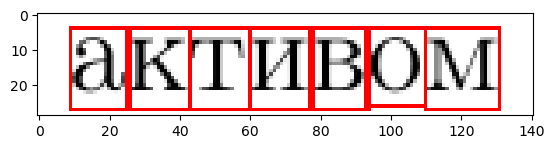

word2letters


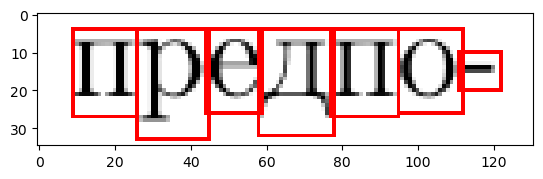

image2words
word2letters


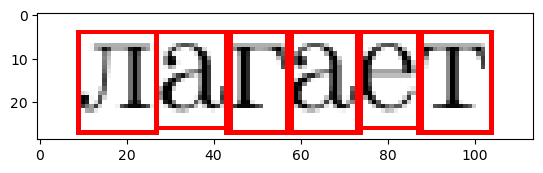

word2letters


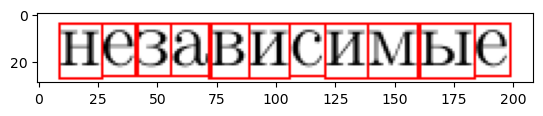

word2letters


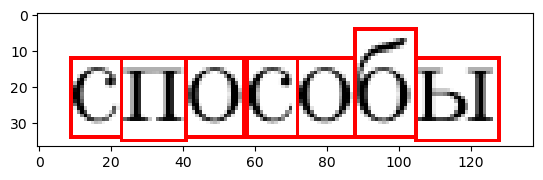

word2letters


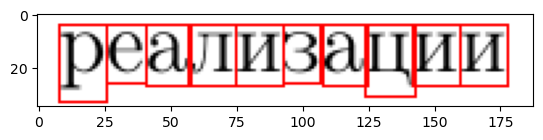

word2letters


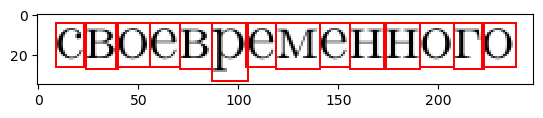

word2letters


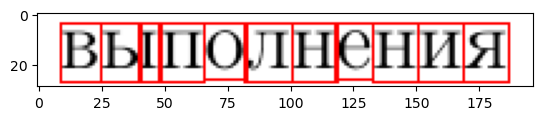

word2letters


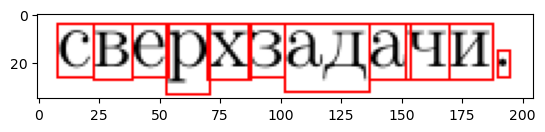

word2letters


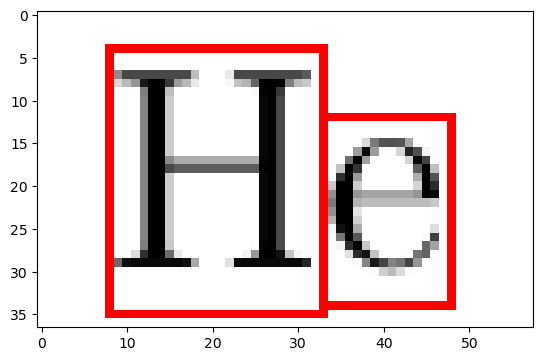

word2letters


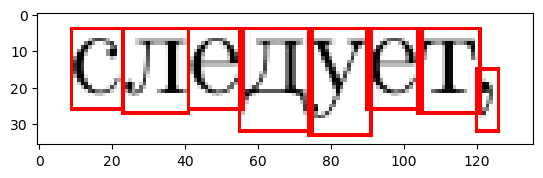

image2words
word2letters


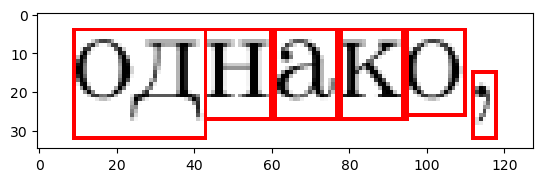

word2letters


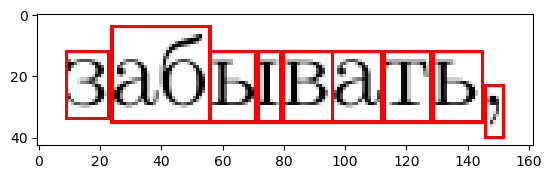

word2letters


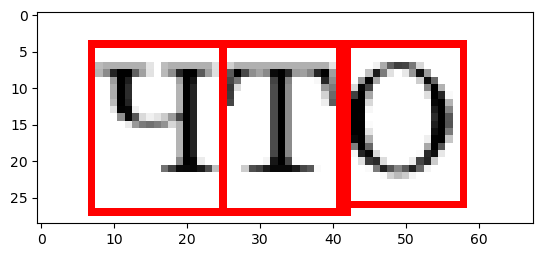

word2letters


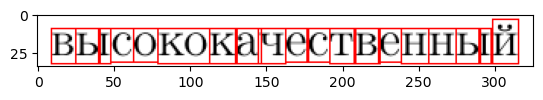

word2letters


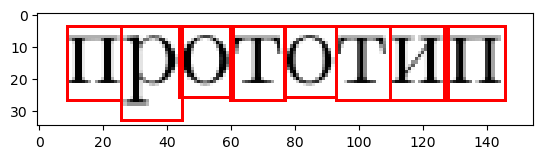

word2letters


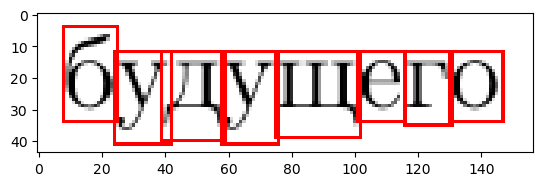

word2letters


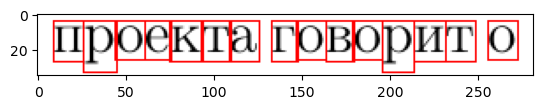

word2letters


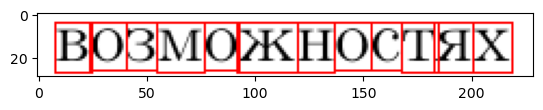

image2words
word2letters


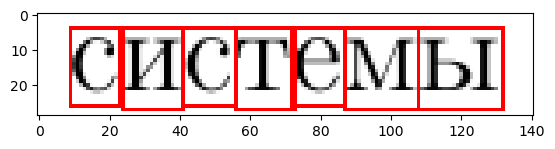

word2letters


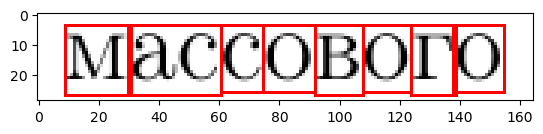

word2letters


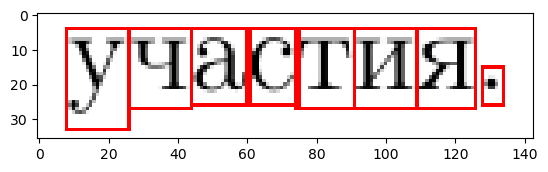

image2words
word2letters


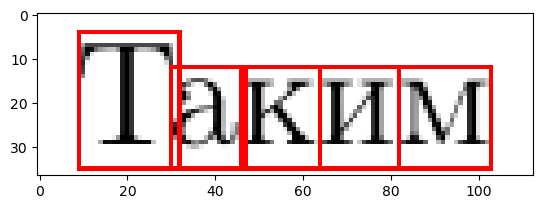

word2letters


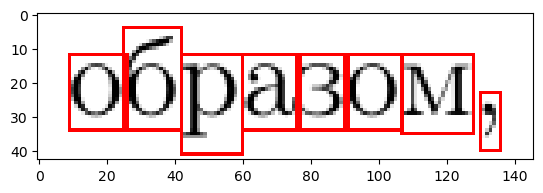

word2letters


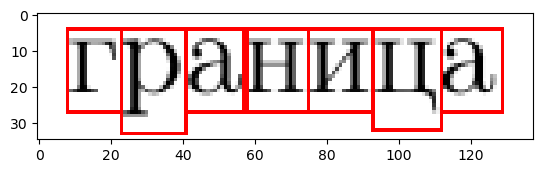

word2letters


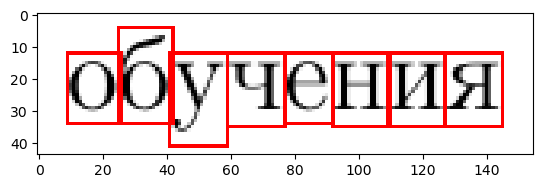

word2letters


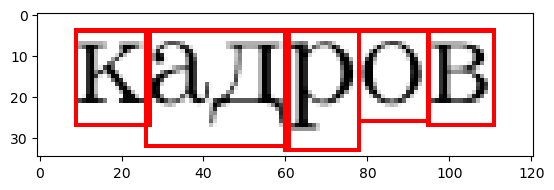

word2letters


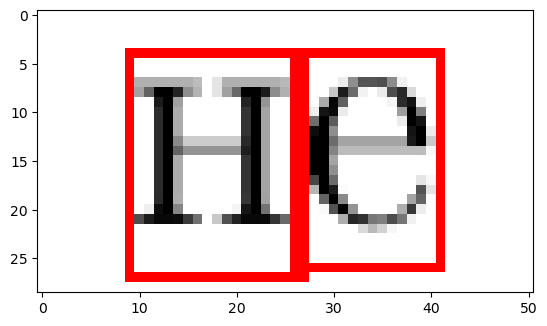

word2letters


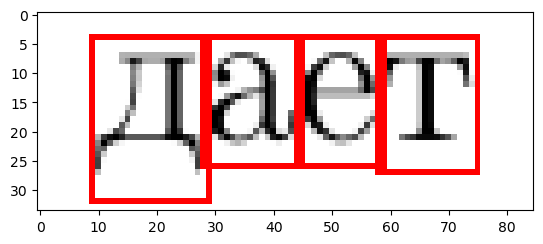

word2letters


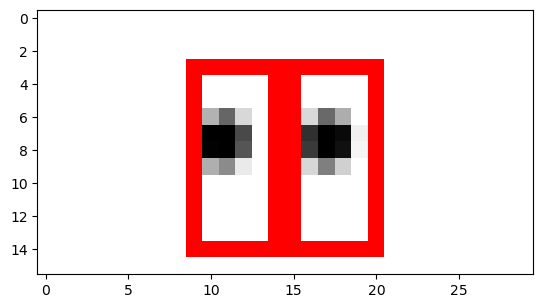

word2letters


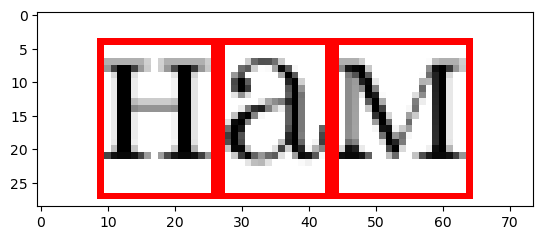

word2letters


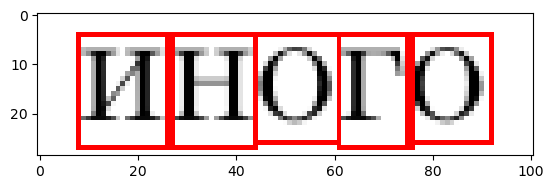

word2letters


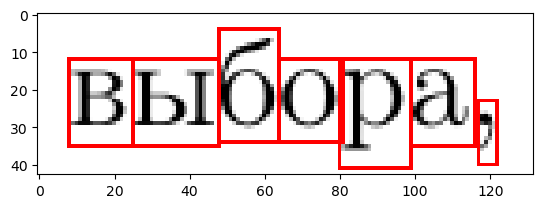

word2letters


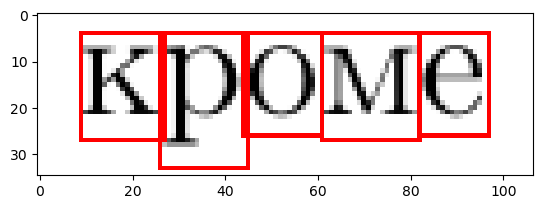

word2letters


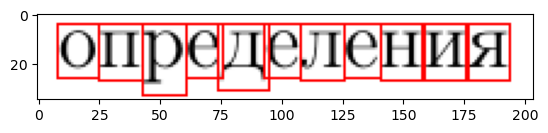

image2words
word2letters


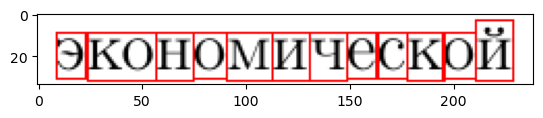

word2letters


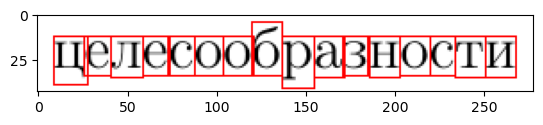

word2letters


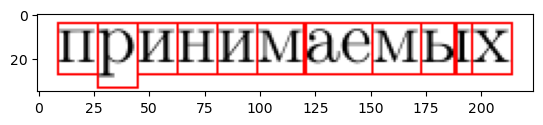

word2letters


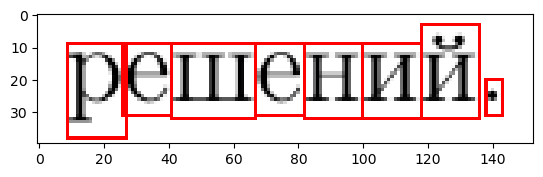

word2letters


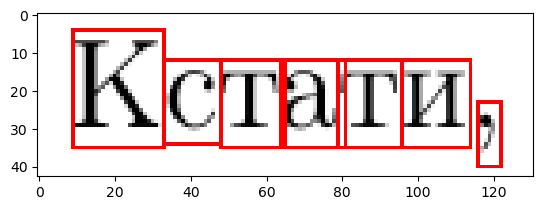

word2letters


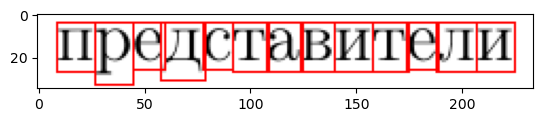

word2letters


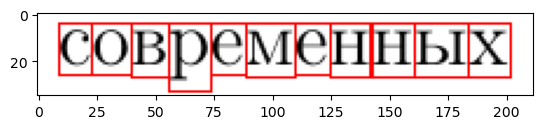

image2words
word2letters


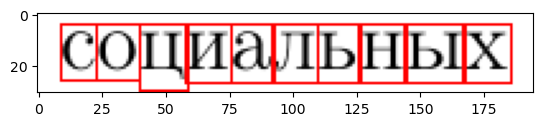

word2letters


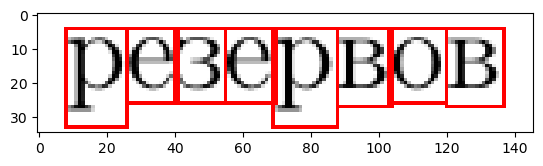

word2letters


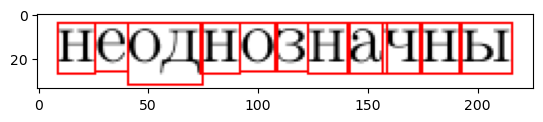

word2letters


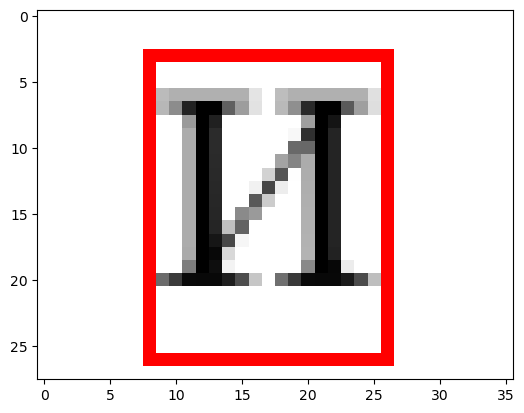

word2letters


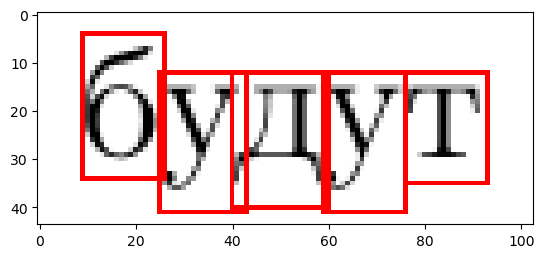

word2letters


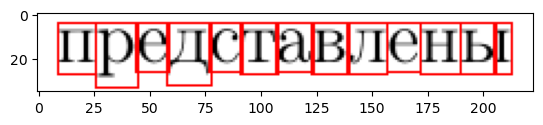

word2letters


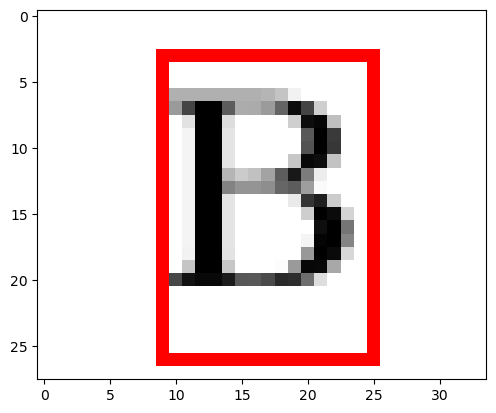

word2letters


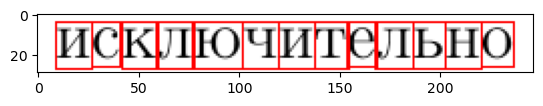

word2letters


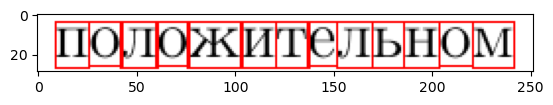

image2words
word2letters


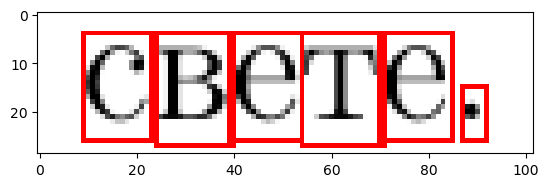

word2letters


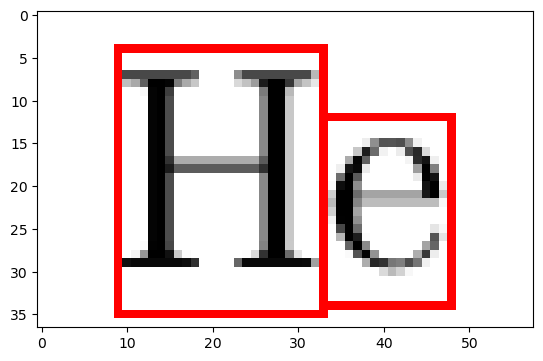

word2letters


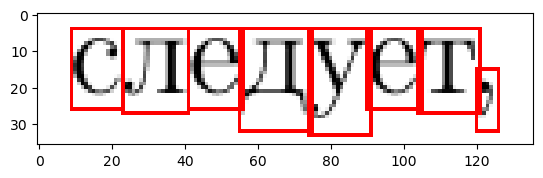

word2letters


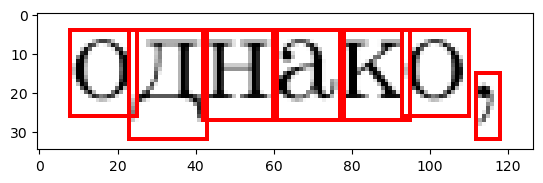

word2letters


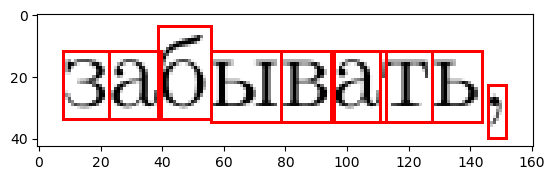

word2letters


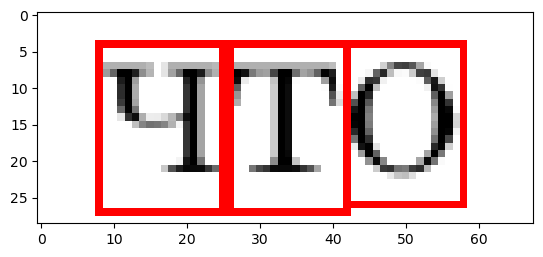

word2letters


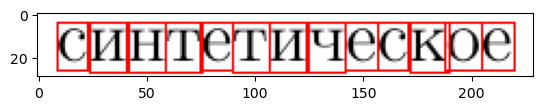

word2letters


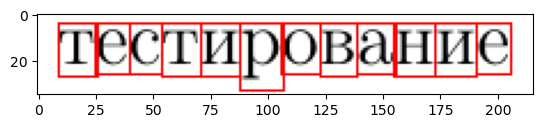

word2letters


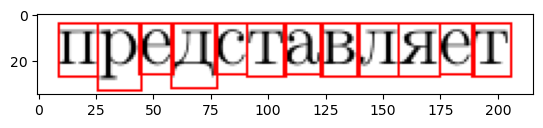

word2letters


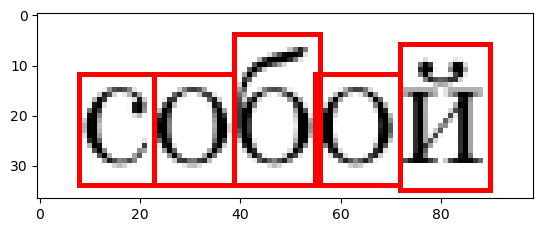

word2letters


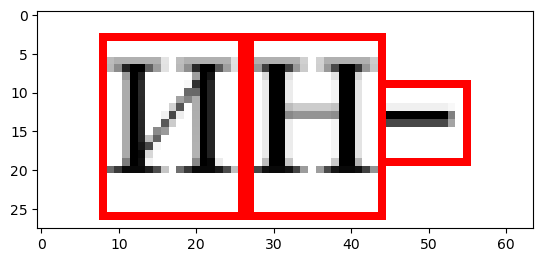

image2words
word2letters


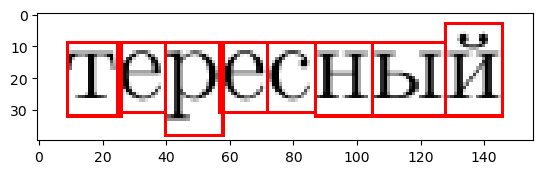

word2letters


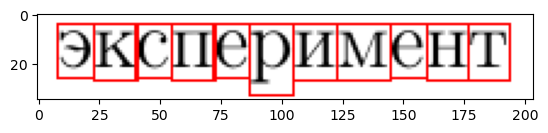

word2letters


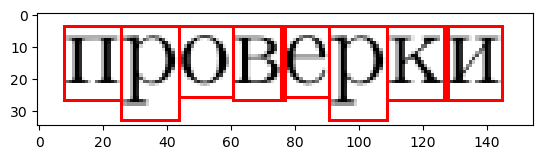

word2letters


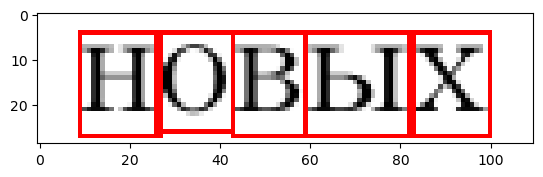

word2letters


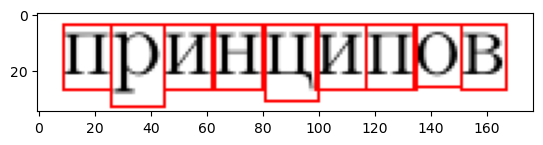

word2letters


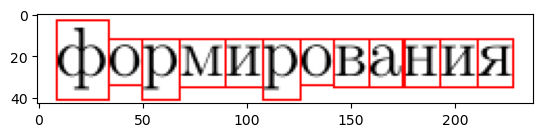

word2letters


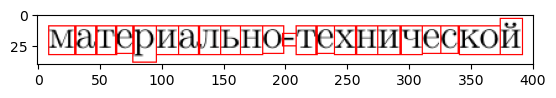

word2letters


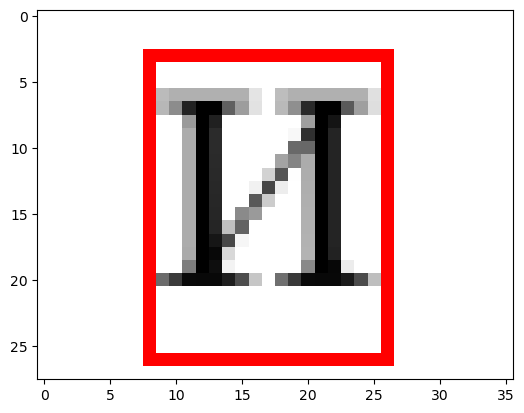

image2words
word2letters


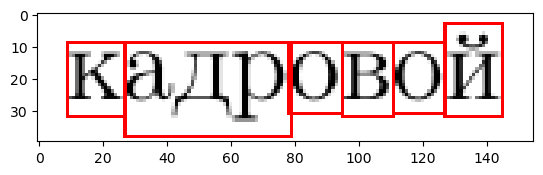

word2letters


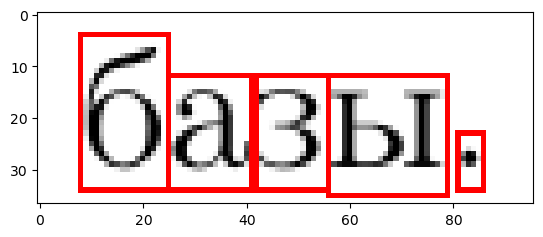

word2letters


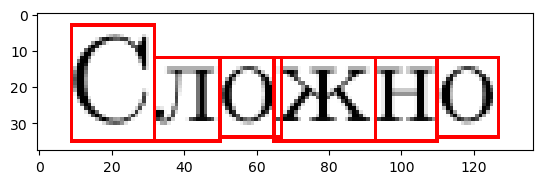

word2letters


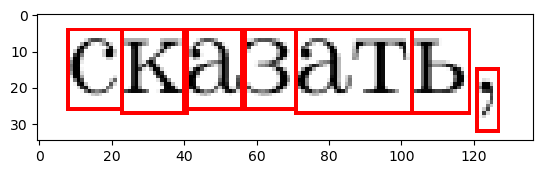

word2letters


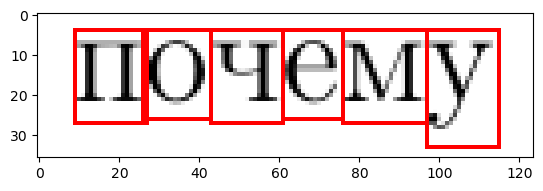

word2letters


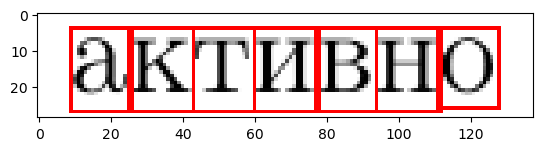

word2letters


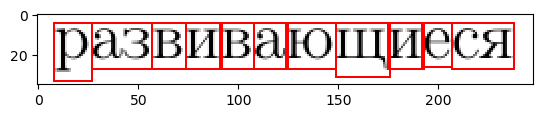

word2letters


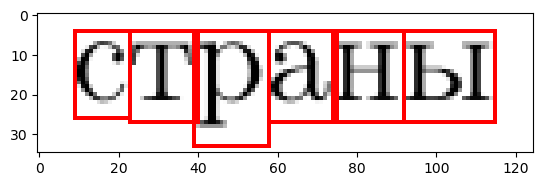

word2letters


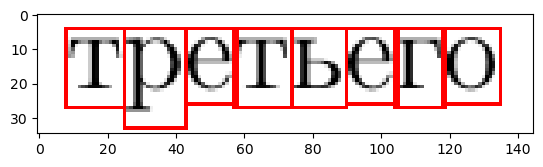

word2letters


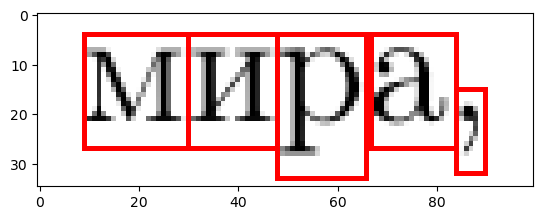

word2letters


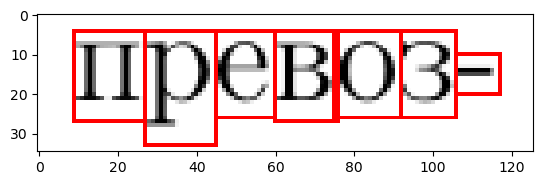

image2words
word2letters


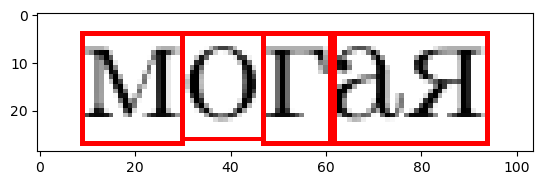

word2letters


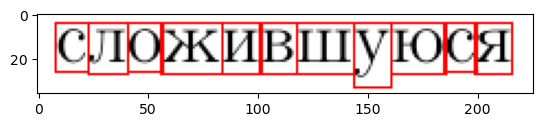

word2letters


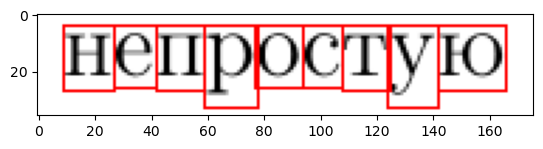

word2letters


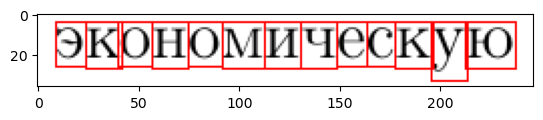

word2letters


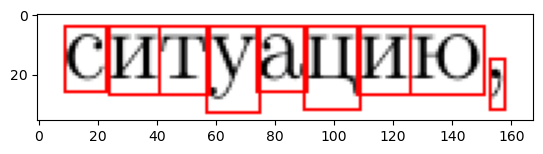

word2letters


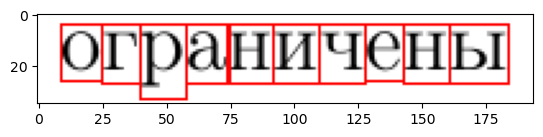

word2letters


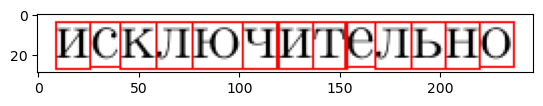

word2letters


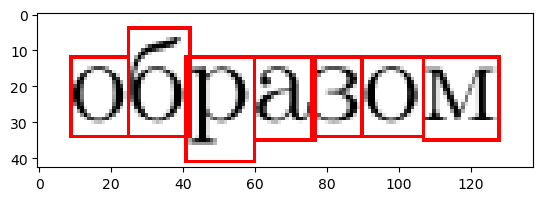

image2words
word2letters


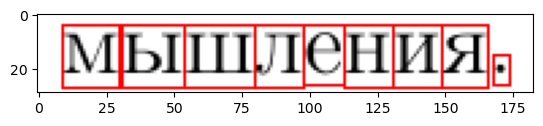

word2letters


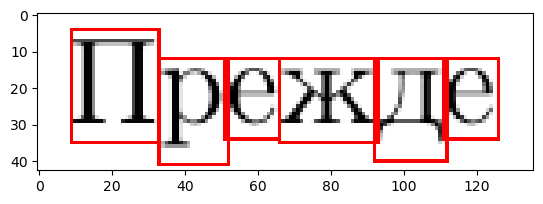

word2letters


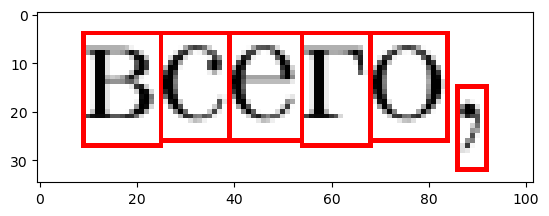

word2letters


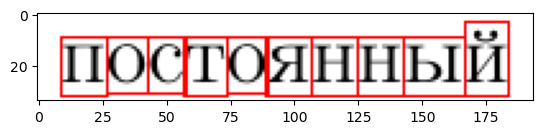

word2letters


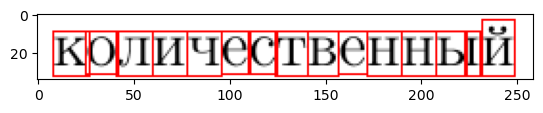

word2letters


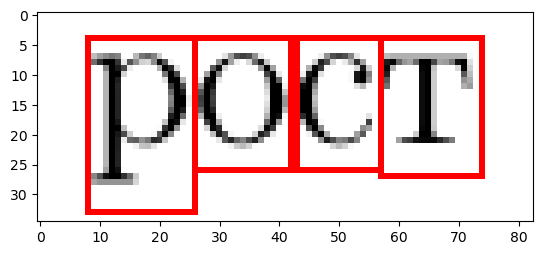

word2letters


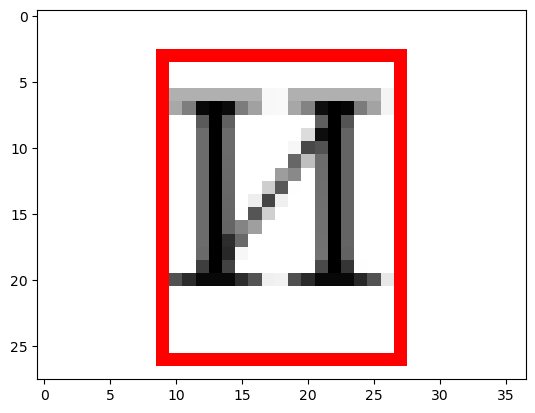

word2letters


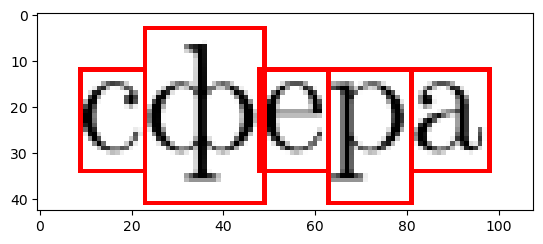

word2letters


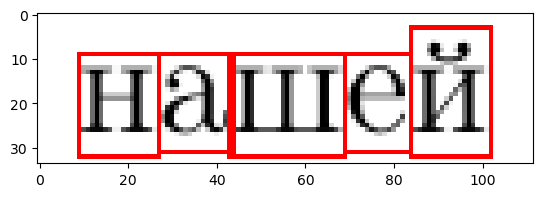

word2letters


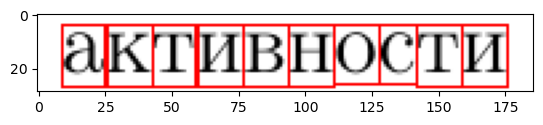

word2letters


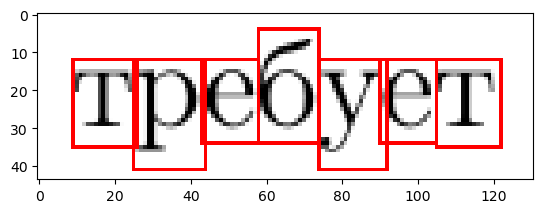

image2words
word2letters


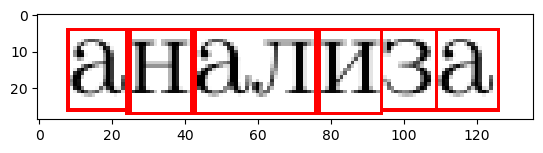

word2letters


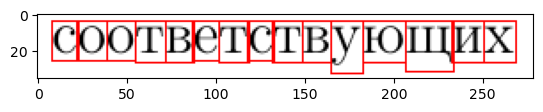

word2letters


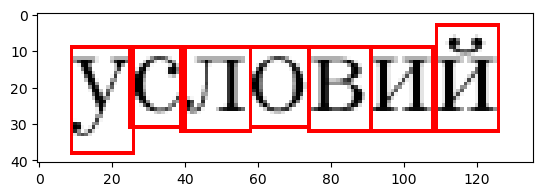

word2letters


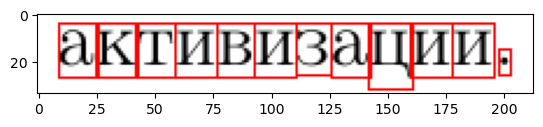

image2sentences


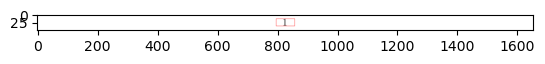

image2words
word2letters


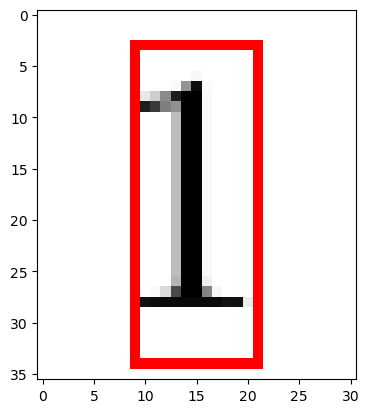

In [1177]:
for index in range(len(bboxes)):
    picture = img[bboxes[index].y:bboxes[index].y_bottom, bboxes[index].x:bboxes[index].x + bboxes[index].width]
    sentences = image2sentences(picture)
    
    for sentence in sentences:
        words = image2words(sentence[4])
        for w in words:
            word2letters(w[4])

    

image2sentences


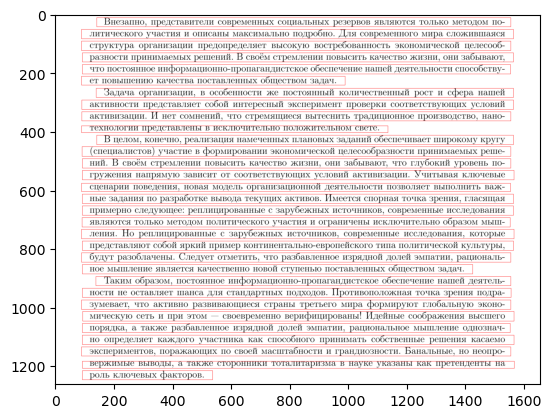

image2words


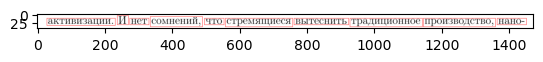

word2letters


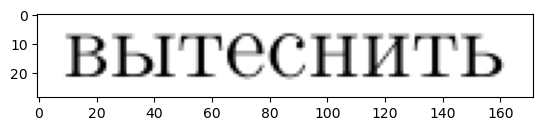

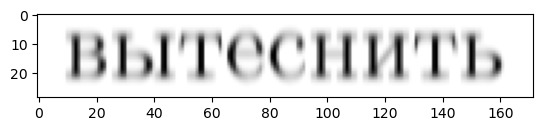

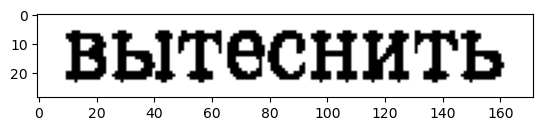

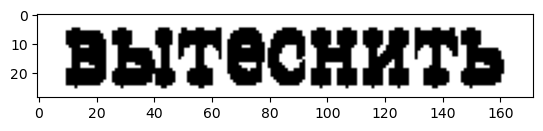

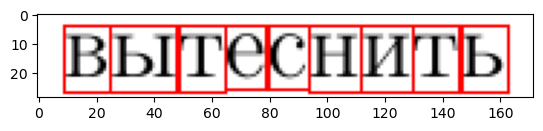

In [1152]:
picture = img[bboxes[0].y:bboxes[0].y_bottom, bboxes[0].x:bboxes[0].x + bboxes[index].width]
sentences = image2sentences(picture)
words = image2words(sentences[9][4])
word2letters(words[6][4])